# SolarPower Forecast: Optimizing Energy Consumption and Panel Efficiency

<table>
    <td><img src="https://lh6.googleusercontent.com/proxy/dNeV0QsKmJAG66rXLtBXLeNXbis4GxeWie-_61aYeXk5OGicKzedF3qPdFnCPVV2aTBm7H6kWLkH_6Uo5Q2BsSvEKShO65W44oxCbUhUrxMIrQ9XVQyW" width="500" />
</table>
<sub>Created by: EL KHAMKHOUMI Naoufal, BOUDRIKA Ilias</sub>

<sub>Supervised By: Pr. T.Masrour</sub>



Ce Notebook a pour objectif de d√©velopper un mod√®le de pr√©vision de la consommation d'√©nergie g√©n√©r√©e par des panneaux solaires photovolta√Øques, afin d'optimiser la production d'√©nergie et de d√©terminer le nombre de panneaux n√©cessaires pour r√©pondre √† la demande √©nerg√©tique, tout en assurant une maintenance pr√©dictive.

<h2><b>Objectif</b></h2>

- **D√©velopper un mod√®le de pr√©vision** de la consommation d'√©nergie en utilisant des panneaux solaires photovolta√Øques, en exploitant les donn√©es historiques de consommation d'√©nergie et de production solaire.
- **Comparer diff√©rentes approches de mod√©lisation** des s√©ries temporelles (ARIMA, LSTM, XGBoost, etc.) pour identifier la m√©thode la plus performante pour pr√©dire la consommation d'√©nergie et la production des panneaux solaires.
- **Analyser les tendances et les facteurs d'influence** (ensoleillement, temp√©rature, encrassement des panneaux, etc.) sur la production d'√©nergie solaire et la demande en √©nergie.
- **√âvaluer les performances du mod√®le** √† l'aide de m√©triques appropri√©es (RMSE, MAE, R¬≤) et optimiser les hyperparam√®tres pour une meilleure pr√©cision dans les pr√©visions.
- **Utiliser les pr√©visions pour d√©terminer le nombre de panneaux solaires n√©cessaires** afin de r√©pondre aux besoins √©nerg√©tiques tout en maximisant l'efficacit√© √©nerg√©tique, et pour effectuer
une maintenance pr√©dictive en d√©tectant des anomalies √©ventuelles dans la production d'√©nergie.

**Veuillez ex√©cuter le code depuis le d√©but, cellule par cellule, pour garantir le bon fonctionnement du Notebook.**



### **√Ä propos des donn√©es**

- **Donn√©es de consommation √©lectrique :** Issues de [NYC OpenData](https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2025-/jr24-e7cr), ces donn√©es fournissent l'historique de la consommation et du co√ªt de l'√©lectricit√© pour divers b√¢timents de la ville de New York.  
- **Donn√©es de production solaire :** Obtenues √† partir du [NSRDB Data Viewer](https://nsrdb.nrel.gov/data-viewer), ces donn√©es incluent des indicateurs cl√©s du rayonnement solaire, tels que l'irradiance horizontale globale (GHI), l'irradiance normale directe (DNI) et l'irradiance horizontale diffuse (DHI), permettant d'estimer la production d'√©nergie solaire.  

# Installation et Importation des Biblioth√®ques

In [1]:
"""import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs
logging.getLogger('tensorflow').setLevel(logging.ERROR)"""

"import logging\nimport os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs\nlogging.getLogger('tensorflow').setLevel(logging.ERROR)"

In [2]:
!pip install pvlib

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19.3/19.3 MB 82.9 MB/s eta 0:00:00:00:0100:01


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pvlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Importation et Pr√©traitement des Donn√©es

In [4]:
# Windows
df_generated = pd.read_csv("/kaggle/input/solarpower-forecast-data/generated_2009_2023.csv")
df_consumed = pd.read_csv("/kaggle/input/solarpower-forecast-data/Electric_Consumption_And_Cost__2010_-_Feb_2025__20250311.csv")

/tmp/ipykernel_31/3446156935.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_consumed = pd.read_csv("/kaggle/input/solarpower-forecast-data/Electric_Consumption_And_Cost__2010_-_Feb_2025__20250311.csv")


## Donn√©es de consommation d'√©nergie

In [5]:
df_consumed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521035 entries, 0 to 521034
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    520414 non-null  object 
 1   Borough             521035 non-null  object 
 2   Account Name        521035 non-null  object 
 3   Location            507102 non-null  object 
 4   Meter AMR           520266 non-null  object 
 5   Meter Scope         27636 non-null   object 
 6   TDS #               519157 non-null  float64
 7   EDP                 521035 non-null  int64  
 8   RC Code             521035 non-null  object 
 9   Funding Source      521035 non-null  object 
 10  AMP #               518672 non-null  object 
 11  Vendor Name         521035 non-null  object 
 12  UMIS BILL ID        521035 non-null  int64  
 13  Revenue Month       521035 non-null  object 
 14  Service Start Date  521027 non-null  object 
 15  Service End Date    521027 non-nul

In [6]:
import os

In [7]:
df_consumed = df_consumed[['Revenue Month', 'Current Charges' ,'Consumption (KWH)']] # R√©cup√©rer les donn√©es pertinentes

df_consumed.rename(columns={'Revenue Month': 'Datetime', 'Current Charges': 'Cost ($)'}, inplace=True) # Renommer la colonne Revenue Month en Datetime

df_consumed.set_index('Datetime', inplace=True) # Mettre la colonne Datetime en index

df_consumed # Verifier les premi√®res lignes

Cost ($)  Consumption (KWH)
Datetime                              
1/1/2011   15396.82           128800.0
2/1/2011   14556.34           115200.0
3/1/2011   13904.98           103200.0
4/1/2011   14764.04           105600.0
5/1/2011   13729.54            97600.0
...             ...                ...
12/1/2023   9687.94            78631.0
12/1/2023  12049.22            97796.0
12/1/2023   3280.56                0.0
12/1/2023   3745.50                0.0
12/1/2023   5043.52                0.0

[521035 rows x 2 columns]

In [8]:
df_consumed.index = pd.to_datetime(df_consumed.index) # Convertir l'index en datetime

df_consumed

Cost ($)  Consumption (KWH)
Datetime                               
2011-01-01  15396.82           128800.0
2011-02-01  14556.34           115200.0
2011-03-01  13904.98           103200.0
2011-04-01  14764.04           105600.0
2011-05-01  13729.54            97600.0
...              ...                ...
2023-12-01   9687.94            78631.0
2023-12-01  12049.22            97796.0
2023-12-01   3280.56                0.0
2023-12-01   3745.50                0.0
2023-12-01   5043.52                0.0

[521035 rows x 2 columns]

Nos donn√©es sont r√©parties sur diff√©rentes parties de New York, nous allons donc les regrouper ensemble.

In [9]:
df_consumed_grouped = df_consumed.groupby(df_consumed.index).sum()
df_consumed_grouped

Cost ($)  Consumption (KWH)
Datetime                                  
2011-01-01  12932094.95       1.062983e+08
2011-02-01  11474423.62       9.313955e+07
2011-03-01  11459508.91       8.847798e+07
2011-04-01  12390753.92       8.907660e+07
2011-05-01  12631326.74       8.963793e+07
...                 ...                ...
2023-08-01  22825232.80       1.199489e+08
2023-09-01  19754972.09       9.811615e+07
2023-10-01  11873141.33       7.680215e+07
2023-11-01  11531474.41       8.622900e+07
2023-12-01  13664901.69       8.440377e+07

[156 rows x 2 columns]

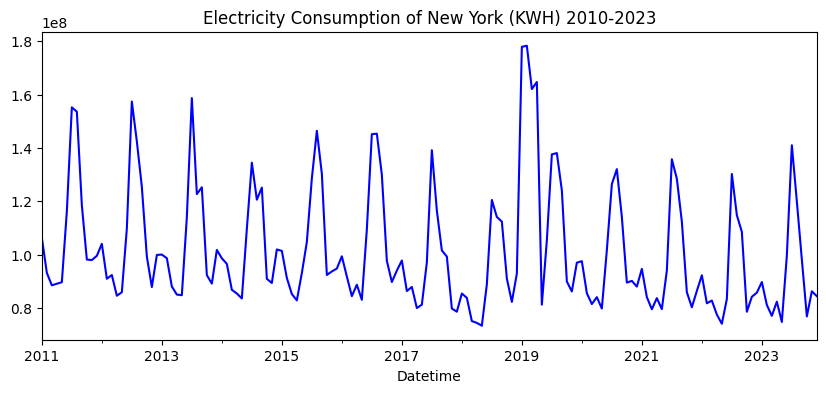

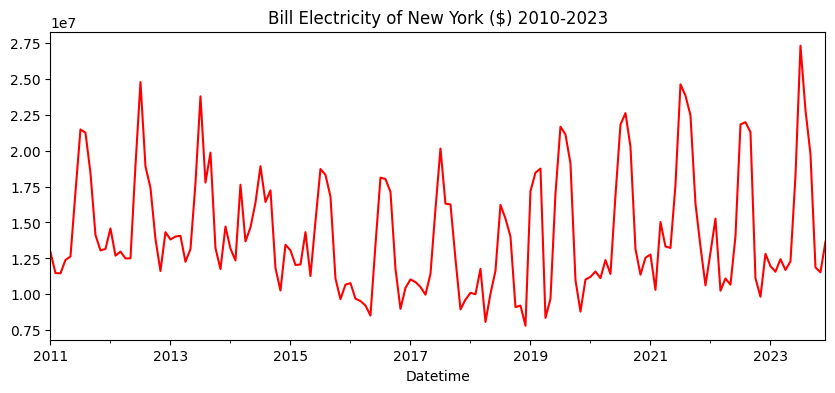

In [10]:
# Plot Consumption (KWH)
df_consumed_grouped['Consumption (KWH)'].plot(figsize=(10, 4), title='Electricity Consumption of New York (KWH) 2010-2023', color='blue')
plt.show()

# Plot Cost ($)
df_consumed_grouped['Cost ($)'].plot(figsize=(10, 4), title='Bill Electricity of New York ($) 2010-2023', color='red')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


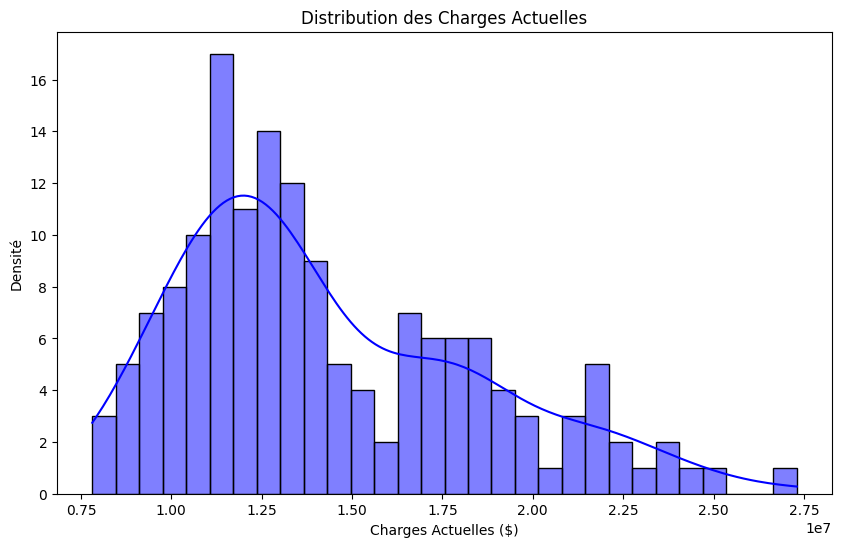

In [11]:
# Tracer la distribution des charges actuelles en utilisant histplot
plt.figure(figsize=(10, 6))
sns.histplot(data = df_consumed_grouped['Cost ($)'], kde=True, bins=30, color='blue')

plt.title('Distribution des Charges Actuelles')
plt.xlabel('Charges Actuelles ($)')
plt.ylabel('Densit√©')

plt.show()

### Data Augmentation

Dans notre dataset, nous avons des donn√©es √† fr√©quence mensuelle. Pour obtenir plus de points de donn√©es et affiner notre analyse, nous allons convertir ces donn√©es en une fr√©quence hebdomadaire.

Cette conversion nous permettra de mieux capturer les tendances et les variations √† une √©chelle de temps plus d√©taill√©e. Pour ce faire, nous allons utiliser la technique de *resampling* pour regrouper les donn√©es par semaine, puis appliquer une m√©thode d'*interpolation* pour estimer les valeurs manquantes entre les points mensuels.

Cette approche nous donnera des donn√©es hebdomadaires sur lesquelles nous pourrons effectuer des analyses plus fines.

### M√©thode :

1. **Resampling** : Nous allons changer la fr√©quence des donn√©es de mensuelle √† hebdomadaire.
2. **Interpolation** : Nous allons estimer les valeurs manquantes en utilisant les valeurs existantes.

Cette transformation nous fournira une vue plus d√©taill√©e de l'√©volution des variables au fil du temps.

In [12]:
# Ajouter de l'al√©atoire pour rendre les donn√©es plus r√©alistes
def creer_donnees_hebdomadaires_avec_variation(donnees_mensuelles, date_debut='2010-01-01', variation=0.15):
    np.random.seed(42)
    donnees_hebdomadaires = []
    index_dates = []
    date_courante = pd.to_datetime(date_debut)

    for valeur_mensuelle in donnees_mensuelles:
        # D√©terminer le nombre de semaines dans le mois
        semaines = 4 + np.random.choice([0, 1])  # 4 ou 5 semaines

        # G√©n√©rer des facteurs de variation
        variations = np.random.normal(loc=1.0, scale=variation, size=semaines)
        variations = variations / variations.sum()  # Normalisation

        # Appliquer les variations aux valeurs hebdomadaires
        valeurs_semaine = valeur_mensuelle * variations

        # Ajouter les donn√©es hebdomadaires
        for valeur in valeurs_semaine:
            donnees_hebdomadaires.append(valeur)
            index_dates.append(date_courante)
            date_courante += timedelta(days=7)

    return pd.Series(donnees_hebdomadaires, index=index_dates)

In [13]:
# G√©n√©rer les donn√©es hebdomadaires
Weekly_energy_consumed = creer_donnees_hebdomadaires_avec_variation(df_consumed_grouped['Consumption (KWH)'])
Weekly_energy_cost= creer_donnees_hebdomadaires_avec_variation(df_consumed_grouped['Cost ($)'])

Weekly_energy_consumed


2010-01-01    2.283354e+07
2010-01-08    2.681183e+07
2010-01-15    2.665663e+07
2010-01-22    2.999627e+07
2010-01-29    1.963609e+07
                  ...     
2023-05-12    1.731015e+07
2023-05-19    2.222881e+07
2023-05-26    2.127110e+07
2023-06-02    1.803241e+07
2023-06-09    2.287144e+07
Length: 702, dtype: float64

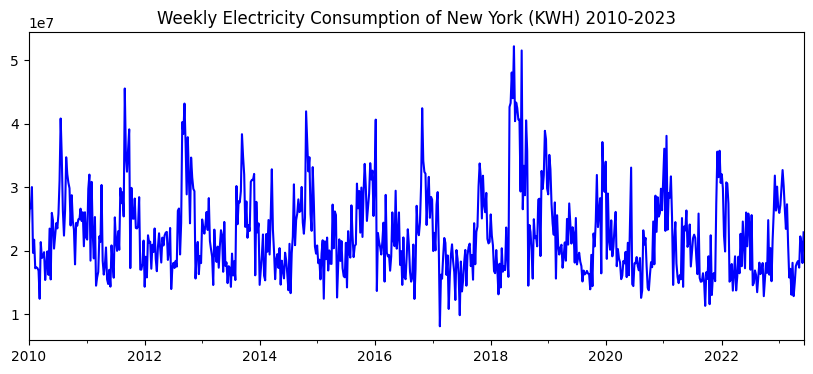

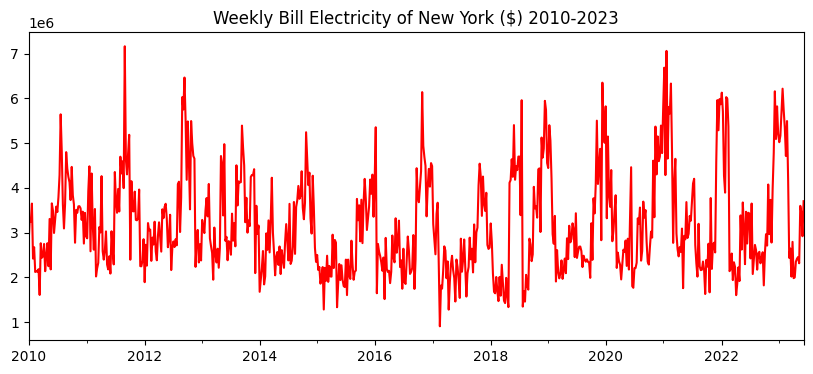

In [14]:
# Plot Consumption (KWH)
Weekly_energy_consumed.plot(figsize=(10, 4), title='Weekly Electricity Consumption of New York (KWH) 2010-2023', color='blue')
plt.show()

# Plot Cost ($)
Weekly_energy_cost.plot(figsize=(10, 4), title='Weekly Bill Electricity of New York ($) 2010-2023', color='red')
plt.show()

## Donn√©es de generation d'√©nergie

In [15]:
df_generated = df_generated[(df_generated['Year'] >= 2010) & (df_generated['Year'] <= 2023)] # Normaliser les donn√©es entre 2010 et 2021


<h3><b>Concernant les donn√©es</b></h3>

Le dataset est compos√© de :  

**Variables de radiation solaire :**

- **DHI** (Irradiance Diffuse Horizontale) ‚Äì *(W/m¬≤)*  
- **DNI** (Irradiance Normale Directe) ‚Äì *(W/m¬≤)*  
- **GHI** (Irradiance Globale Horizontale) ‚Äì *(W/m¬≤)*  

**Conditions m√©t√©orologiques :**  
- **Temp√©rature** *(¬∞C)*  
- **Angle Z√©nithal Solaire** *(¬∞)* ‚Äì Indique la position du soleil par rapport √† la verticale. Un angle √©lev√© signifie que le soleil est bas dans le ciel, ce qui r√©duit l‚Äôirradiance re√ßue.  

In [16]:
df_generated # Afficher les donn√©es g√©n√©r√©es

Year  Month  Day  Hour  Minute  Temperature  Solar Zenith Angle  GHI  \
8760    2010      1    1     0      30          0.7              121.59    0   
8761    2010      1    1     1      30          0.5              132.94    0   
8762    2010      1    1     2      30          0.2              144.05    0   
8763    2010      1    1     3      30          0.2              154.18    0   
8764    2010      1    1     4      30          0.2              161.23    0   
...      ...    ...  ...   ...     ...          ...                 ...  ...   
131467  2023     12   31    19      30          5.8               72.75   43   
131468  2023     12   31    20      30          4.7               80.32   13   
131469  2023     12   31    21      30          3.9               89.08    3   
131470  2023     12   31    22      30          3.7               99.63    0   
131471  2023     12   31    23      30          3.7              110.44    0   

        DHI  DNI  
8760      0    0  
8761      0    0  
8762      0    0  
8763      0    0  
8764      0    0  
...     ...  ...  
131467   43    0  
131468   13    0  
131469    3    0  
131470    0    0  
131471    0    0  

[122712 rows x 10 columns]

In [17]:
# Convertir les colonnes de temps en un format datetime
df_generated['Datetime'] = pd.to_datetime(df_generated[['Year', 'Month', 'Day', 'Hour']])

# D√©finir la colonne datetime comme index du DataFrame
df_generated.set_index('Datetime', inplace=True)

# Supprimer les colonnes d'origine li√©es au temps, car elles sont maintenant redondantes
df_generated.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

# Afficher les premi√®res lignes du DataFrame pour v√©rifier le r√©sultat
print(df_generated.head())

                     Temperature  Solar Zenith Angle  GHI  DHI  DNI
Datetime                                                           
2010-01-01 00:00:00          0.7              121.59    0    0    0
2010-01-01 01:00:00          0.5              132.94    0    0    0
2010-01-01 02:00:00          0.2              144.05    0    0    0
2010-01-01 03:00:00          0.2              154.18    0    0    0
2010-01-01 04:00:00          0.2              161.23    0    0    0


In [18]:
df_generated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122712 entries, 2010-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         122712 non-null  float64
 1   Solar Zenith Angle  122712 non-null  float64
 2   GHI                 122712 non-null  int64  
 3   DHI                 122712 non-null  int64  
 4   DNI                 122712 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 5.6 MB


# Irradiance en Plan des Modules (POA)

## Qu'est-ce que l'irradiance POA ?
L'irradiance en plan des modules (Plane of Array - POA) d√©signe la quantit√© de rayonnement solaire re√ßue par une surface inclin√©e, comme un panneau solaire, plut√¥t qu'une surface horizontale. Elle est essentielle pour estimer avec pr√©cision la production d'√©nergie des syst√®mes photovolta√Øques (PV), car les panneaux solaires sont g√©n√©ralement install√©s √† un angle et non √† plat.

L'irradiance POA comprend trois composantes principales :
1. **Irradiance directe (beam)** : Lumi√®re solaire atteignant directement le panneau sans diffusion.
2. **Irradiance diffuse** : Lumi√®re solaire diffus√©e par l‚Äôatmosph√®re et re√ßue depuis plusieurs directions.
3. **Irradiance r√©fl√©chie (alb√©do)** : Lumi√®re solaire r√©fl√©chie par le sol ou des surfaces environnantes vers le panneau.

## M√©thode de calcul
L‚Äôirradiance POA ($ G_{POA} $) est obtenue en additionnant les contributions de ces trois composantes :

$$
G_{POA} = G_{b,POA} + G_{d,POA} + G_{r,POA}
$$

O√π :
- $ G_{b,POA} $ = Irradiance normale directe (DNI - Direct Normal Irradiance)
- $ G_{d,POA} $ = Irradiance horizontale diffuse (DHI - Diffuse Horizontal Irradiance)
- $ G_{r,POA} $ = Irradiance r√©fl√©chie par le sol

Avec :

**<h4>1. l'angle d'incidence (AOI) :</h4>**

$$
\cos(\theta) = \cos(\beta) \sin(E) + \sin(\beta) \cos(E) \cos(A_s - A_p)
$$

O√π :  
- $E$ = Angle d'√©l√©vation solaire  
- $A_s$ = Angle azimutal du soleil  
- $A_p$ = Angle azimutal du panneau  
- $\beta$ = Angle d'inclinaison du panneau  

**<h4>2. Composante directe de l'irradiance POA :</h4>**

$$
G_{b, POA} = G_b \cos(\theta)
$$

O√π $G_b$ est l'**irradiance normale directe (DNI)**.

**<h4>3. Composante diffuse de l'irradiance POA (Mod√®le isotropique)</h4>**

$$
G_{d, POA} = G_d \times \frac{1 + \cos(\beta)}{2}
$$

O√π $G_d$ est l'**irradiance horizontale diffuse (DHI)**.

**<h4>4. Composante r√©fl√©chie de l'irradiance POA (Alb√©do)</h4>**
$$
G_{r, POA} = G \times \rho \times \frac{1 - \cos(\beta)}{2}
$$

O√π :  
- $G$ = **Irradiance horizontale globale (GHI)**  
- $\rho$ = **Alb√©do (coefficient de r√©flexion du sol)**

Le calcul de l‚Äôirradiance POA permet une meilleure estimation des performances des panneaux solaires dans des conditions r√©elles..


Pour l'angle d'√©l√©vation solaire (SEA), nous pouvons utiliser l'angle de zenith solaire (SZA) pour le calculer avec la formule suivante :  
$$ SEA = 90^\circ - SZA $$

Pour l'angle d'azimut solaire, nous allons utiliser la biblioth√®que `pvlib` afin de l'extraire avec pr√©cision.

In [19]:
# Calcule de l'angle d'elevation solaire
df_generated["Solar Elevation"] = 90 - df_generated["Solar Zenith Angle"]

# Define location coordinates (Pour notre dataset: New York City)
latitude = 40.73
longitude = -74.02

# Generate an hourly datetime range from 2010 to 2023
time_range = pd.date_range(start="2010-01-01", end="2023-12-31 23:00:00", freq="H")

# Calculate solar position using pvlib
solar_positions = pvlib.solarposition.get_solarposition(time_range, latitude, longitude)

# Extract azimuth values
solar_azimuth = solar_positions['azimuth']

# Create a DataFrame to store results
df_azimuth = pd.DataFrame({'Datetime': time_range, "Solar Azimuth": solar_azimuth})

# Display first rows
print(df_azimuth.head())

/tmp/ipykernel_31/2429804742.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start="2010-01-01", end="2023-12-31 23:00:00", freq="H")


                               Datetime  Solar Azimuth
2010-01-01 00:00:00 2010-01-01 00:00:00     261.078818
2010-01-01 01:00:00 2010-01-01 01:00:00     270.376425
2010-01-01 02:00:00 2010-01-01 02:00:00     281.270480
2010-01-01 03:00:00 2010-01-01 03:00:00     296.102129
2010-01-01 04:00:00 2010-01-01 04:00:00     320.278205


In [20]:
merged_df = pd.merge(df_generated, df_azimuth[['Datetime', "Solar Azimuth"]], on='Datetime', how='left') # Combiner Azimuth et les donn√©es g√©n√©r√©es

merged_df.set_index('Datetime', inplace=True) # D√©finir la colonne datetime comme index du DataFrame


merged_df = merged_df.drop(columns=['Solar Zenith Angle']) # Car on a deja calculer le SEA

# Afficher les premi√®res lignes du DataFrame pour v√©rifier le r√©sultat
print(merged_df)

                     Temperature  GHI  DHI  DNI  Solar Elevation  \
Datetime                                                           
2010-01-01 00:00:00          0.7    0    0    0           -31.59   
2010-01-01 01:00:00          0.5    0    0    0           -42.94   
2010-01-01 02:00:00          0.2    0    0    0           -54.05   
2010-01-01 03:00:00          0.2    0    0    0           -64.18   
2010-01-01 04:00:00          0.2    0    0    0           -71.23   
...                          ...  ...  ...  ...              ...   
2023-12-31 19:00:00          5.8   43   43    0            17.25   
2023-12-31 20:00:00          4.7   13   13    0             9.68   
2023-12-31 21:00:00          3.9    3    3    0             0.92   
2023-12-31 22:00:00          3.7    0    0    0            -9.63   
2023-12-31 23:00:00          3.7    0    0    0           -20.44   

                     Solar Azimuth  
Datetime                            
2010-01-01 00:00:00     261.078818  
2010

<Axes: title={'center': 'Irradiation globale [W/m2] en fonction du temps'}, xlabel='Datetime', ylabel='Irradiation globale [W/m2]'>

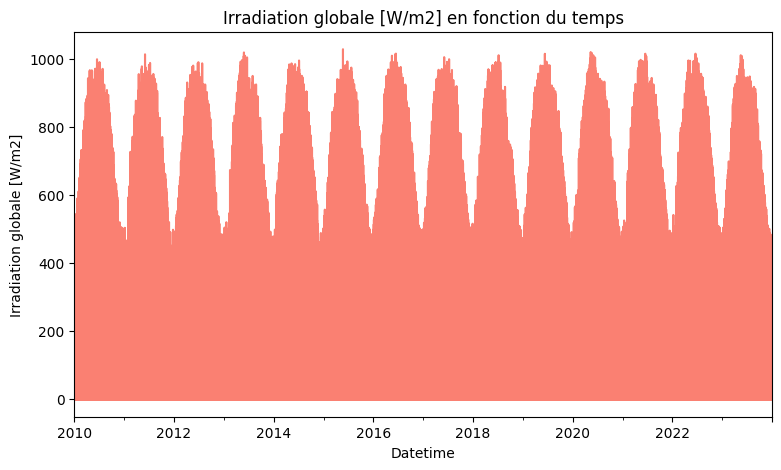

In [21]:
# Calculer l'irradiance globale du Plan de l'Array (POA)

# D√©finir l'angle d'inclinaison du panneau solaire (b√™ta) en degr√©s
beta = 5

# D√©finir l'angle d'azimut du panneau solaire (azimut) en degr√©s
azimut = 180

# D√©finir l'alb√©do (rho) de l'environnement environnant
rho = 0.2

# Convertir l'angle d'√©l√©vation du soleil en radians
elevation = np.radians(merged_df['Solar Elevation'])

# Convertir l'angle d'azimut du soleil en radians
azimut_s = np.radians(merged_df['Solar Azimuth'])

# Calculer le cosinus de l'angle d'incidence (cos_aoi)
cos_aoi = np.cos((np.pi/180)*beta) * np.sin(elevation) + np.sin((np.pi/180)*beta) * np.cos(elevation) * np.cos(azimut_s - azimut)

# Calculer le composant direct de l'irradiance POA (poa_b)
poa_b = np.clip(merged_df['DNI'] * cos_aoi, 0, None)

# Calculer le composant diffus de l'irradiance POA (poa_d)
poa_d = np.clip(merged_df['DHI'] * (1 + np.cos(beta*np.pi/180)) / 2, 0, None)

# Calculer le composant r√©fl√©chi de l'irradiance POA (poa_r)
poa_r = np.clip(merged_df['GHI'] * rho * (1 - np.cos(beta*np.pi/180)) / 2, 0, None)

# Calculer l'irradiance globale totale POA (gpoa) en additionnant les composants direct, diffus et r√©fl√©chi
gpoa = poa_b + poa_d + poa_r

# Tracer l'irradiance globale POA au fil du temps
gpoa.plot(title=("Irradiation globale [W/m2] en fonction du temps"), ylabel=("Irradiation globale [W/m2]"), figsize=(9,5), color=('salmon'))

# Calcul de la Temp√©rature de la Cellule et de la Puissance

Dans cette section, nous allons estimer la temp√©rature de la cellule et la puissance g√©n√©r√©e par les panneaux solaires √† l'aide de deux mod√®les : le **mod√®le de Ross** pour la temp√©rature et le **mod√®le PVWatts** pour la puissance DC. Nous utiliserons l'irradiance POA et la temp√©rature ambiante comme principales variables.

### 1. **Calcul de la Temp√©rature de la Cellule**
La temp√©rature de la cellule solaire ($T_c$) est calcul√©e en utilisant le **mod√®le de Ross**. Ce mod√®le relie la temp√©rature de la cellule √† la temp√©rature ambiante ($T_a$) et √† l'irradiance. L‚Äô√©quation utilis√©e est la suivante :

$$
T_c = T_a + k_{\text{ross}} \times G_{\text{POA}}
$$

O√π :
- $T_a$ = Temp√©rature ambiante (en ¬∞C)  
- $k_{\text{ross}}$ = Coefficient de temp√©rature, calcul√© √† partir de la temp√©rature nominale de fonctionnement de la cellule (NOCT) et d‚Äôune irradiance de r√©f√©rence de 800 W/m¬≤
- $G_{\text{POA}}$ = Irradiance globale re√ßue par le panneau (en W/m¬≤)

Nous r√©cup√©rons la temp√©rature ambiante ($T_a$) √† partir des donn√©es d‚Äôentr√©e et appliquons la formule pour obtenir la temp√©rature de la cellule.


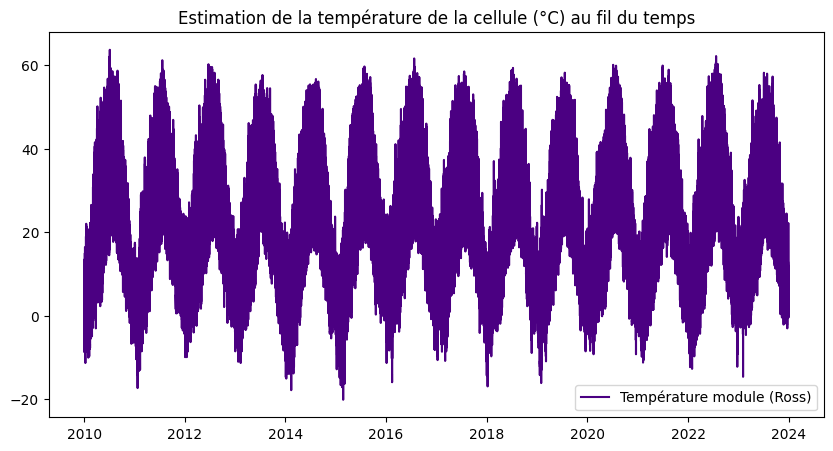

In [22]:
# Calculer la temp√©rature de la cellule

# R√©cup√©rer la temp√©rature ambiante (Ta) √† partir des donn√©es d'entr√©e
Ta = merged_df['Temperature']

# D√©finir la temp√©rature nominale de fonctionnement de la cellule (Noct) en ¬∞C
Noct = 43

# Calculer le coefficient de temp√©rature (kross) pour le mod√®le de Ross
kross = (Noct - 20) / 800

# Mod√®le de Ross : calculer la temp√©rature de la cellule (Tc_ross) en utilisant la temp√©rature ambiante, le coefficient de temp√©rature, et l'irradiance globale
Tc_ross = Ta + kross * gpoa

# Tracer les estimations de la temp√©rature des cellules des deux mod√®les au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(Tc_ross, label='Temp√©rature module (Ross)', color='indigo')  # Tracer le mod√®le de Ross
plt.title('Estimation de la temp√©rature de la cellule (¬∞C) au fil du temps')  # D√©finir le titre du graphique
plt.legend()  # Afficher la l√©gende

### 2. **Calcul de la Puissance DC**
La **puissance DC** g√©n√©r√©e par les panneaux solaires est ensuite estim√©e √† l‚Äôaide du **mod√®le PVWatts**. Ce mod√®le prend en compte l'irradiance et la temp√©rature pour ajuster la puissance g√©n√©r√©e par rapport aux conditions r√©elles. L‚Äô√©quation utilis√©e est la suivante :

$$
P_{\text{DC}} = P_{dc0} \times \left( \frac{G_{\text{POA}}}{1000} \right) \times \left(1 + \gamma_{\text{coief}} \times (T_c - 25)\right)
$$

O√π :
- $P_{dc0}$ = Puissance de r√©f√©rence en watts (ici, 300 W par [panneau](https://www.enfsolar.com/pv/panel-datasheet/crystalline/65662?utm_source=ENF&utm_medium=panel_profile&utm_campaign=enquiry_company_directory&utm_content=77684) multipli√© par le nombre de panneaux)
- $G_{\text{POA}}$ = Irradiance globale du plan des modules
- $\gamma_{\text{coief}}$ = Coefficient de temp√©rature de la puissance DC
- $T_c$ = Temp√©rature de la cellule

Pour r√©f√©rence, prenons une petite station avec 10 000 panneaux de 750 W chacun. La station Noor Ouarzazate, l'une des plus grandes centrales solaires au monde, poss√®de environ 200 000 panneaux.

**Panneau de reference:** [SR6-HJT725-750M](https://www.enfsolar.com/pv/panel-datasheet/crystalline/65662?utm_source=ENF&utm_medium=panel_profile&utm_campaign=enquiry_company_directory&utm_content=77684)

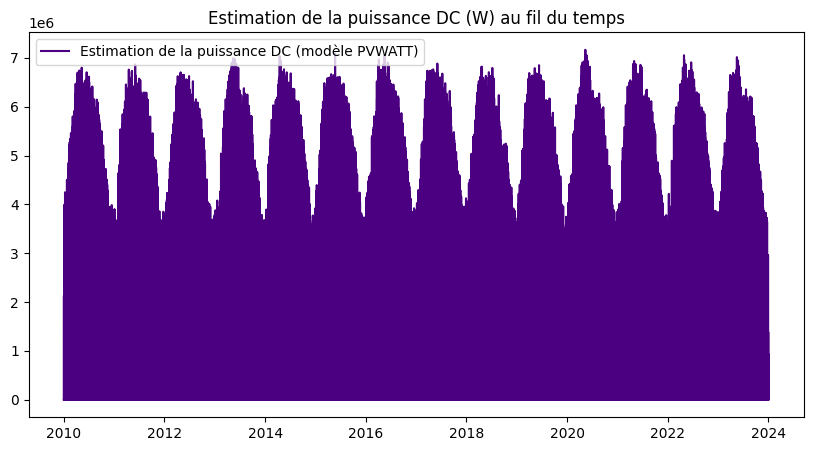

In [23]:
# Calculer la puissance continue (DC)

# D√©finir la puissance DC de r√©f√©rence (Pdc0) en watts
Pdc0 = 750 * 10000  # 750 W par panneau * 10000 panneaux

# D√©finir le coefficient de temp√©rature (gamma_coief) pour le mod√®le PVWatts
gamma_coief = -0.0037

# Calculer l'irradiance normalis√©e (g_prime) en divisant l'irradiance du plan de l'array (gpoa) par 1000
g_prime = gpoa / 1000

# Calculer la temp√©rature normalis√©e (T_prime) en soustrayant 25 de la temp√©rature de la cellule (Tc_ross)
T_prime = Tc_ross - 25

# Mod√®le de puissance PVWatts : calculer la puissance DC (Pdc_watts) en utilisant la puissance de r√©f√©rence, l'irradiance, et la temp√©rature
Pdc_watts = Pdc0 * (gpoa / 1000) * (1 + gamma_coief * (Tc_ross - 25))

# Tracer les estimations de la puissance DC des deux mod√®les au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(Pdc_watts, label='Estimation de la puissance DC (mod√®le PVWATT)', color='indigo')  # Tracer le mod√®le PVWatts
plt.title('Estimation de la puissance DC (W) au fil du temps')
plt.legend()

### 3. **Conversion de la Puissance DC en Puissance AC**
La **puissance AC** est ensuite calcul√©e √† partir de la puissance DC en utilisant l'efficacit√© de l'onduleur ($\eta$) :

$$
P_{\text{AC}} = P_{\text{DC}} \times \eta
$$

O√π :
- $\eta$ = Efficacit√© de l'onduleur (valeur typique entre 0.85 et 0.95)

Le mod√®le de conversion de la puissance DC en AC prend en compte les pertes d'efficacit√© dues √† l'onduleur.

Ces √©tapes permettront d'estimer la temp√©rature des cellules et la puissance g√©n√©r√©e par les panneaux solaires au fil du temps.

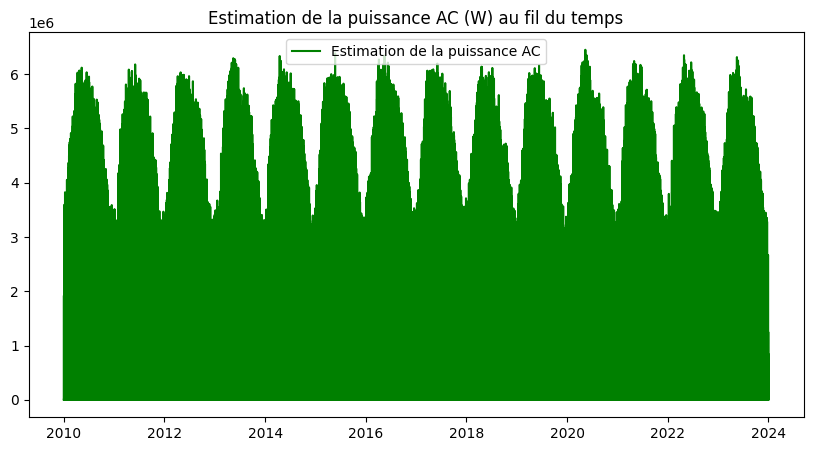

In [24]:
# D√©finir l'efficacit√© de l'onduleur (efficacit√© typique entre 0.85 et 0.95)
eta = 0.9

# Calculer la puissance AC (P_ac) en utilisant la puissance DC (P_dc) et l'efficacit√© de l'onduleur
P_ac = Pdc_watts * eta

# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(P_ac, label='Estimation de la puissance AC', color='green')  # Tracer la puissance AC estim√©e
plt.title('Estimation de la puissance AC (W) au fil du temps')  # D√©finir le titre du graphique
plt.legend()  # Afficher la l√©gende

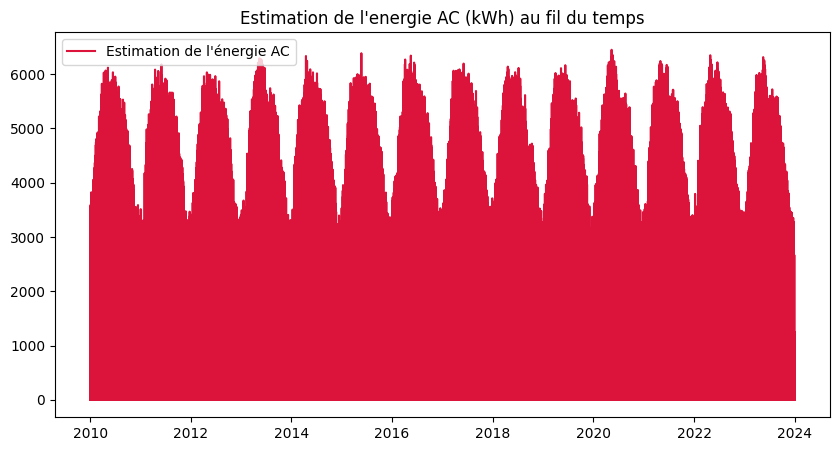

In [25]:
# Puisque la puissance est d√©j√† exprim√©e par heure, l'√©nergie (Wh) reste la m√™me. Nous allons simplement la convertir en kWh.
E_ac = P_ac /1000

# Tracer les estimations de l'energie AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac, label="Estimation de l'√©nergie AC", color='crimson')  # Tracer la puissance AC estim√©e
plt.title("Estimation de l'energie AC (kWh) au fil du temps")  # D√©finir le titre du graphique
plt.legend()  # Afficher la l√©gende

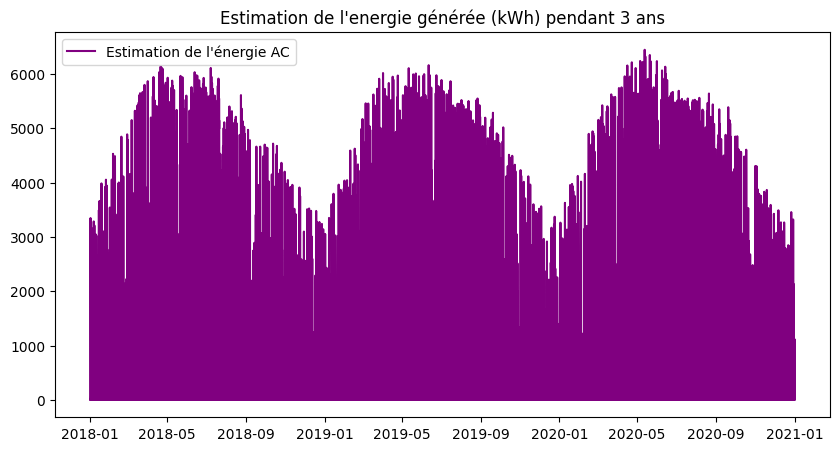

In [26]:
# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac['2018':'2020'], label="Estimation de l'√©nergie AC", color='Purple')  # Tracer la puissance AC estim√©e
plt.title("Estimation de l'energie g√©n√©r√©e (kWh) pendant 3 ans")  # D√©finir le titre du graphique
plt.legend()  # Afficher la l√©gende

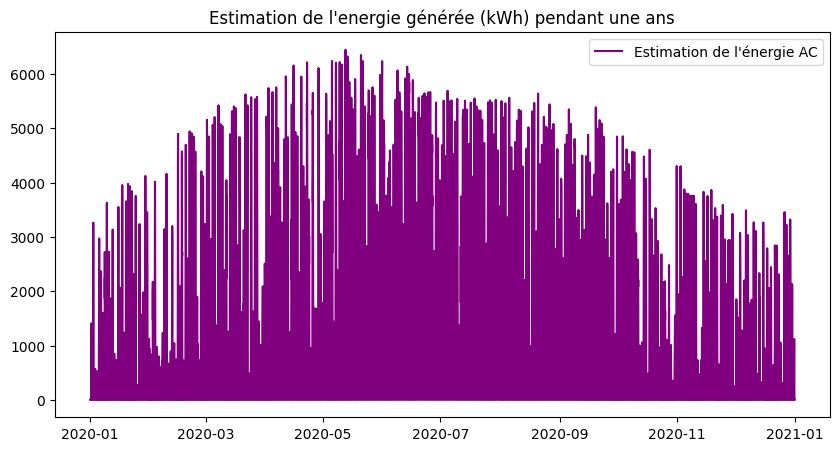

In [27]:
# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac['2020'], label="Estimation de l'√©nergie AC", color='Purple')  # Tracer la puissance AC estim√©e
plt.title("Estimation de l'energie g√©n√©r√©e (kWh) pendant une ans")  # D√©finir le titre du graphique
plt.legend()  # Afficher la l√©gende

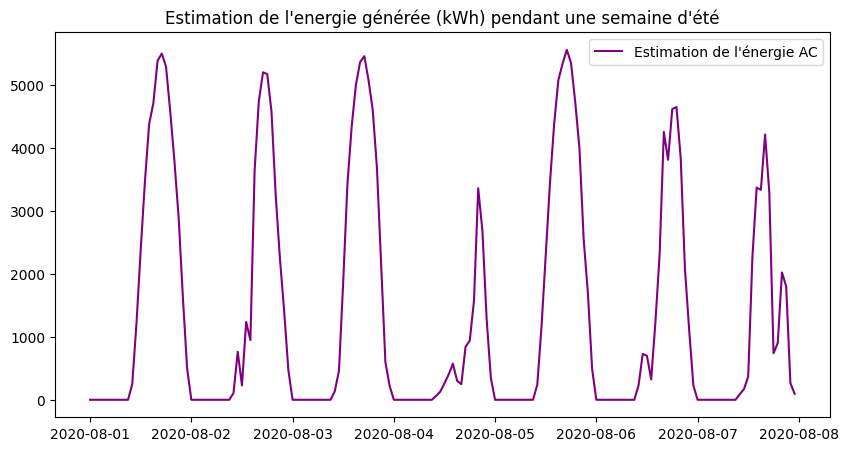

In [28]:
# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac['2020-08-01':'2020-08-07'], label="Estimation de l'√©nergie AC", color='Purple')  # Tracer la puissance AC estim√©e
plt.title("Estimation de l'energie g√©n√©r√©e (kWh) pendant une semaine d'√©t√©")  # D√©finir le titre du graphique
plt.legend()  # Afficher la l√©gende

# Later

In [29]:
"""# Param√®tres pour creation de windowed data
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000 """

'# Param√®tres pour creation de windowed data\nwindow_size = 20\nbatch_size = 32\nshuffle_buffer_size = 1000 '

In [30]:
"""def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    G√©n√®re les fen√™tres du jeu de donn√©es

    Arguments:
      series (tableau de flottants) - contient les valeurs de la s√©rie temporelle
      window_size (int) - le nombre de pas de temps √† moyenner
      batch_size (int) - la taille du lot
      shuffle_buffer (int) - taille du tampon √† utiliser pour la m√©thode de m√©lange

    Retourne:
      dataset (TF Dataset) - Jeu de donn√©es TensorFlow contenant des fen√™tres temporelles


    # G√©n√©rer un jeu de donn√©es TensorFlow √† partir des valeurs de la s√©rie
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Fen√™trer les donn√©es mais ne prendre que celles de la taille sp√©cifi√©e
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Aplatir les fen√™tres en pla√ßant ses √©l√©ments dans un seul lot
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Cr√©er des tuples avec des caract√©ristiques et des √©tiquettes
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # M√©langer les fen√™tres
    dataset = dataset.shuffle(shuffle_buffer)

    # Cr√©er des lots de fen√™tres
    dataset = dataset.batch(batch_size)

    # Optimiser le jeu de donn√©es pour l'entra√Ænement
    dataset = dataset.cache().prefetch(1)

    return dataset"""

"def windowed_dataset(series, window_size, batch_size, shuffle_buffer):\n    G√©n√®re les fen√™tres du jeu de donn√©es\n\n    Arguments:\n      series (tableau de flottants) - contient les valeurs de la s√©rie temporelle\n      window_size (int) - le nombre de pas de temps √† moyenner\n      batch_size (int) - la taille du lot\n      shuffle_buffer (int) - taille du tampon √† utiliser pour la m√©thode de m√©lange\n\n    Retourne:\n      dataset (TF Dataset) - Jeu de donn√©es TensorFlow contenant des fen√™tres temporelles\n\n\n    # G√©n√©rer un jeu de donn√©es TensorFlow √† partir des valeurs de la s√©rie\n    dataset = tf.data.Dataset.from_tensor_slices(series)\n\n    # Fen√™trer les donn√©es mais ne prendre que celles de la taille sp√©cifi√©e\n    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)\n\n    # Aplatir les fen√™tres en pla√ßant ses √©l√©ments dans un seul lot\n    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))\n\n    # Cr√©er

In [31]:
"""# G√©n√©rer les fen√™tres du jeu de donn√©es
dataset = windowed_dataset(normalized_series, window_size, batch_size, shuffle_buffer_size)"""

'# G√©n√©rer les fen√™tres du jeu de donn√©es\ndataset = windowed_dataset(normalized_series, window_size, batch_size, shuffle_buffer_size)'

# Introduction sur les s√©ries temporelle

**Une s√©rie temporelle** est une s√©quence de donn√©es collect√©es √† intervalles r√©guliers et ordonn√©e chronologiquement. La s√©rie temporelle peut √™tre d√©compos√©e en trois composants principaux :

1.   **Trend $(T)$:** Long-term movement in the data.
2.   **Saisonnalit√© $(S)$ :** Cycles courts et r√©p√©titifs dans les donn√©es.
3.   **Bruit $(N)$ :** Variations irr√©guli√®res ou al√©atoires.

$$ y_t = T_t + S_t + N_t $$

Dans nos donn√©es, on peut remarquer une saisonnalit√© quotidienne ainsi qu'une saisonnalit√© annuelle., nous allons explorer cela plus en d√©tail dans la prochaine partie.

# Construction du Model
Pour la construction du **mod√®le**, nous allons d'abord exp√©rimenter avec diff√©rentes approches de **s√©ries temporelles** pour faire une pr√©diction. Nous commencerons par utiliser un **pipeline** pour explorer et d√©terminer quel **mod√®le** est le plus adapt√© aux donn√©es. Ce processus nous permettra de pr√©dire les valeurs futures bas√©es sur les donn√©es pass√©es, en tenant compte de l'autocorr√©lation, de la tendance, et √©ventuellement de la saisonnalit√©. Ensuite, nous ajusterons **les param√®tres du mod√®le s√©lectionn√©** pour obtenir la meilleure performance.

## Pipeline d‚ÄôAnalyse d‚Äôune Serie Temporelle
![Solar Panel](./resources/pipeline.png)

## Analyse de stationnarit√©
L'analyse de stationnarit√© est cruciale en time series car beaucoup de mod√®les (ARIMA, etc.) supposent une stationnarit√©. Une s√©rie non stationnaire peut contenir des tendances ou saisonnalit√©s qui faussent les pr√©visions. On utilise des tests comme **KPSS** pour la d√©tecter et on la transforme (diff√©renciation, log, etc.) si n√©cessaire. üöÄ

In [32]:
E_generated = E_ac
E_consumed = Weekly_energy_consumed
e_cout = Weekly_energy_cost

In [33]:
# D√©finir les s√©ries √† tester
series = {
    "√ânergie g√©n√©r√©e": E_generated,
    "√ânergie consomm√©e": E_consumed,
    "Co√ªt d'√©nergie": e_cout
}

# Effectuer les tests KPSS et ADF pour chaque s√©rie et afficher les r√©sultats
for name, data in series.items():
    print('--------------------------------------------------------')
    # Test KPSS
    kpss_stat, kpss_p_value, _, _ = kpss(data, regression='ct', nlags="auto")  # 'ct' (constant et tendance)
    print(f"\nüîç R√©sultats du test KPSS pour {name}:")
    print(f"   - KPSS Statistic: {kpss_stat:.4f}")
    print(f"   - P-value: {kpss_p_value:.4f}")

    # Interpr√©tation du test KPSS
    if kpss_p_value < 0.05:
        print("   ‚ùå Rejet de H0 ‚Üí La s√©rie est NON stationnaire üìâ")
    else:
        print("   ‚úÖ On ne rejette pas H0 ‚Üí La s√©rie est stationnaire üìä")

    # Test ADF
    adf_stat, adf_p_value, _, _, _, _ = adfuller(data)
    print(f"\nüîç R√©sultats du test ADF pour {name}:")
    print(f"   - ADF Statistic: {adf_stat:.4f}")
    print(f"   - P-value: {adf_p_value:.4f}")

    # Interpr√©tation du test ADF
    if adf_p_value < 0.05:
        print("   ‚úÖ Rejet de H0 ‚Üí La s√©rie est stationnaire üìä")
    else:
        print("   ‚ùå On ne rejette pas H0 ‚Üí La s√©rie est NON stationnaire üìâ")


--------------------------------------------------------

üîç R√©sultats du test KPSS pour √ânergie g√©n√©r√©e:
   - KPSS Statistic: 0.0445
   - P-value: 0.1000
   ‚úÖ On ne rejette pas H0 ‚Üí La s√©rie est stationnaire üìä


/tmp/ipykernel_31/1433411821.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, _, _ = kpss(data, regression='ct', nlags="auto")  # 'ct' (constant et tendance)



üîç R√©sultats du test ADF pour √ânergie g√©n√©r√©e:
   - ADF Statistic: -18.6766
   - P-value: 0.0000
   ‚úÖ Rejet de H0 ‚Üí La s√©rie est stationnaire üìä
--------------------------------------------------------

üîç R√©sultats du test KPSS pour √ânergie consomm√©e:
   - KPSS Statistic: 0.0499
   - P-value: 0.1000
   ‚úÖ On ne rejette pas H0 ‚Üí La s√©rie est stationnaire üìä

üîç R√©sultats du test ADF pour √ânergie consomm√©e:
   - ADF Statistic: -7.9073
   - P-value: 0.0000
   ‚úÖ Rejet de H0 ‚Üí La s√©rie est stationnaire üìä
--------------------------------------------------------

üîç R√©sultats du test KPSS pour Co√ªt d'√©nergie:
   - KPSS Statistic: 0.1238
   - P-value: 0.0911
   ‚úÖ On ne rejette pas H0 ‚Üí La s√©rie est stationnaire üìä

üîç R√©sultats du test ADF pour Co√ªt d'√©nergie:
   - ADF Statistic: -8.0875
   - P-value: 0.0000
   ‚úÖ Rejet de H0 ‚Üí La s√©rie est stationnaire üìä


/tmp/ipykernel_31/1433411821.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, _, _ = kpss(data, regression='ct', nlags="auto")  # 'ct' (constant et tendance)


### Interpr√©tation des r√©sultats des tests

Les trois **tests KPSS** et **ADF** indiquent que la s√©rie est **stationnaire**. Toutefois, nous savons qu‚Äôelle pr√©sente une **saisonnalit√© journali√®re** li√©e √† l‚Äôalternance **jour/nuit** ainsi qu‚Äôune **saisonnalit√© annuelle** due aux **variations saisonni√®res**.

## Analyse de la structure temporelle

L'objectif de cette section est d'examiner la structure temporelle de la s√©rie afin d'identifier les caract√©ristiques essentielles qui guideront la mod√©lisation. Pour cela, nous analyserons :

- **Autocorr√©lation et autocorr√©lation partielle** :  
  - La fonction d'autocorr√©lation (ACF) permet d'observer la d√©pendance entre les observations √† diff√©rents d√©calages (lags).  
  - La fonction d'autocorr√©lation partielle (PACF) aide √† identifier l'ordre potentiel des mod√®les AR et MA.  

- **D√©composition de la s√©rie** :  
  - S√©paration en composantes : tendance, saisonnalit√© et r√©sidu.  
  - Identification de la pr√©sence de cycles ou de structures sp√©cifiques.  

Cette analyse nous permettra d‚Äôorienter le choix des mod√®les adapt√©s (ARIMA, SARIMA, etc.) en fonction des caract√©ristiques d√©tect√©es.  

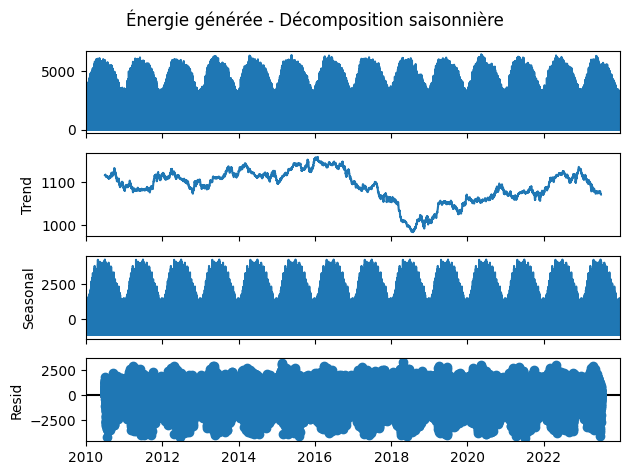

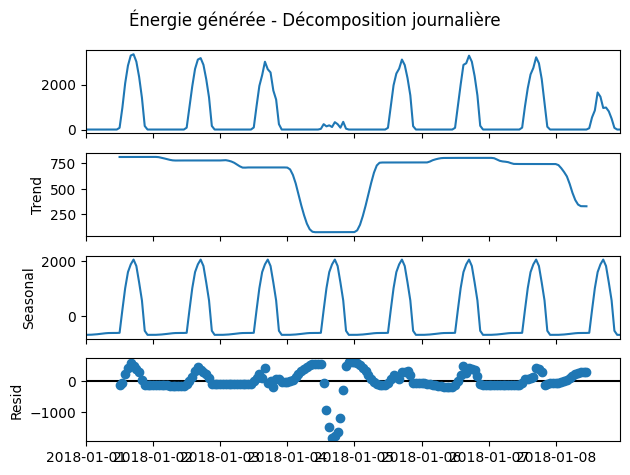

In [34]:
# D√©composer la s√©rie temporelle en composants saisonniers, tendance et r√©sidus
result = seasonal_decompose(E_generated, model='additive', period=(24*365)) # P√©riode annuelle
# Tracer les composants
result.plot()
plt.suptitle("√ânergie g√©n√©r√©e - D√©composition saisonni√®re")
plt.tight_layout()
plt.show()


result = seasonal_decompose(E_generated['2018-01-01':'2018-01-08'], model='additive', period=24) # P√©riode journali√®re

result.plot()
plt.suptitle("√ânergie g√©n√©r√©e - D√©composition journali√®re")
plt.tight_layout()
plt.show()



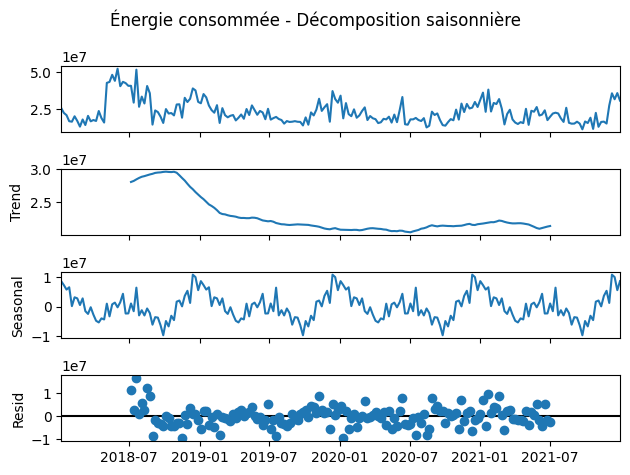

In [35]:
result = seasonal_decompose(E_consumed['2018':'2021'], model='additive', period=52) # P√©riode annuelle (52 semaines dans une ann√©e)

result.plot()
plt.suptitle("√ânergie consomm√©e - D√©composition saisonni√®re")
plt.tight_layout()
plt.show()

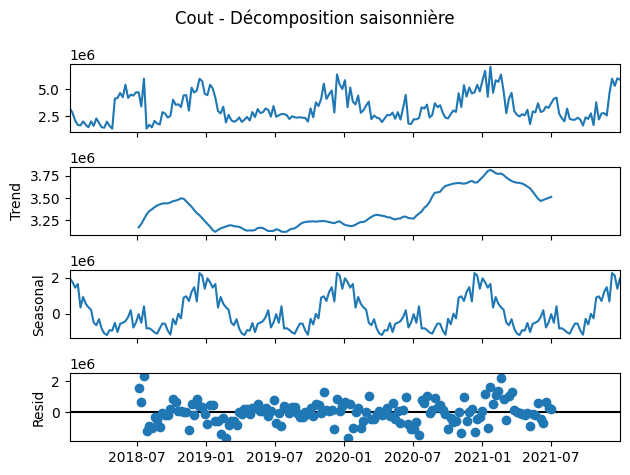

In [36]:
result = seasonal_decompose(e_cout['2018':'2021'], model='additive', period=52) # P√©riode annuelle (52 semaines dans une ann√©e)

result.plot()
plt.suptitle("Cout - D√©composition saisonni√®re")
plt.tight_layout()
plt.show()

### Interpretation globale des resultat de decomposition:

- Le **cout** suit une tendance croissante, contrairement √† **l'√©nergie consomm√©e** et **g√©n√©r√©e**. .
- La composante saisonni√®re indique des fluctuations p√©riodiques, sugg√©rant une forte influence des saisons ou d‚Äôautres facteurs r√©currents pour **les trois series**.
- Les r√©sidus montrent qu‚Äôil y a des variations inexpliqu√©es, peut-√™tre dues √† des √©v√©nements exceptionnels (pannes, changements de politique √©nerg√©tique, etc.).

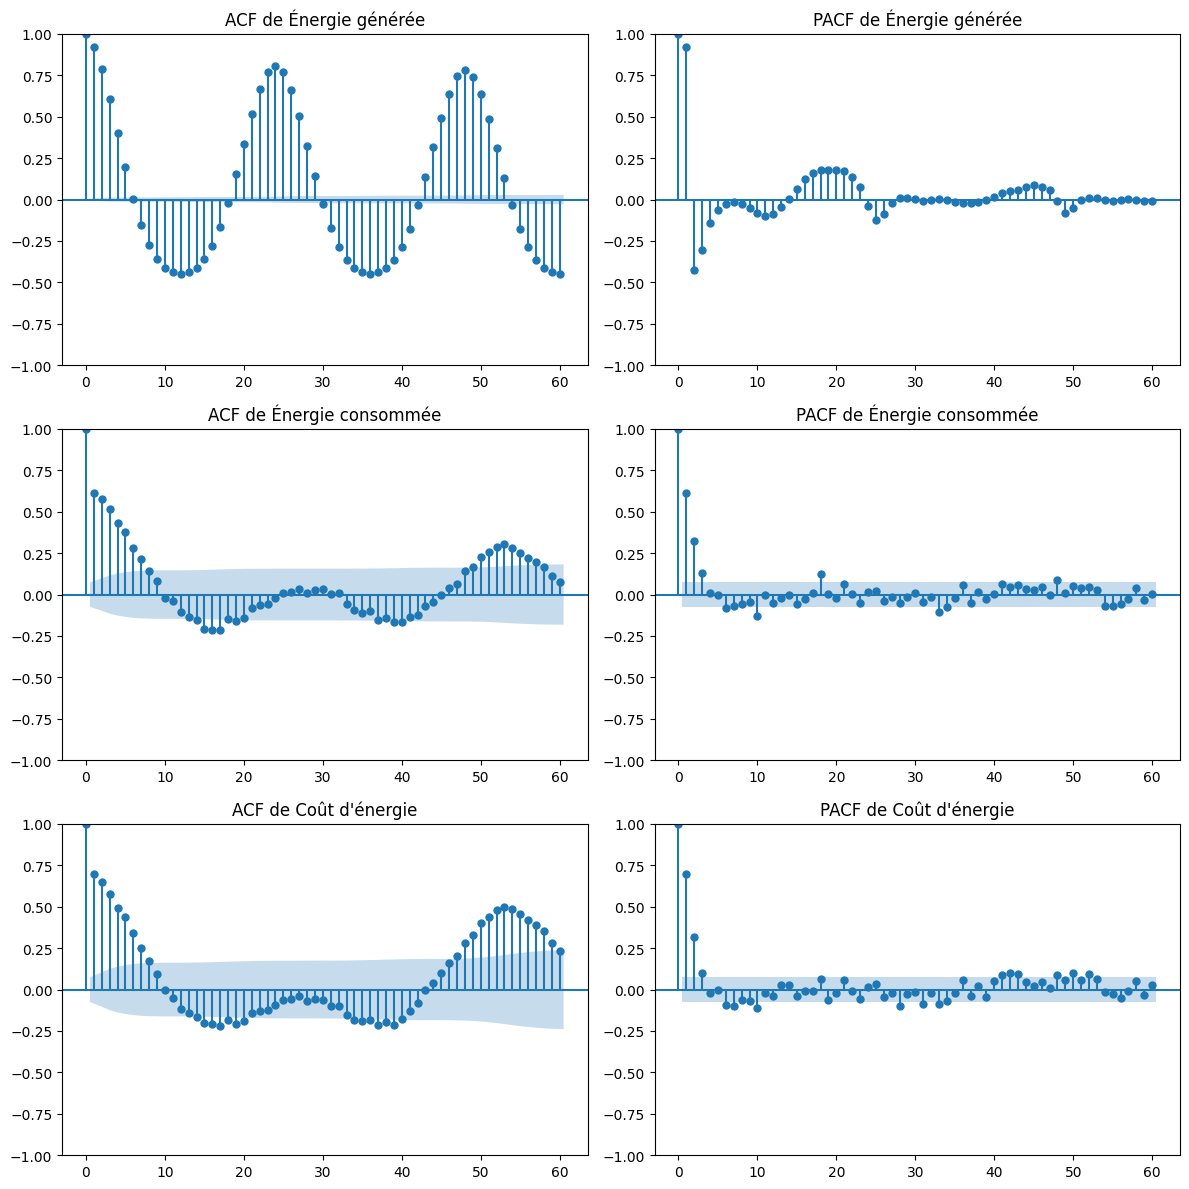

In [37]:
fig, axes = plt.subplots(len(series), 2, figsize=(12, 4 * len(series)))

for i, (name, data) in enumerate(series.items()):

    # Plot ACF
    sm.graphics.tsa.plot_acf(data, lags=60, ax=axes[i, 0])
    axes[i, 0].set_title(f"ACF de {name}")

    # Plot PACF
    sm.graphics.tsa.plot_pacf(data, lags=60, ax=axes[i, 1])
    axes[i, 1].set_title(f"PACF de {name}")

plt.tight_layout()
plt.show()

### Interpretation globale des resultat d'ACF/PACF :

- L'**ACF sinuso√Ødal** de l'**√ânergie g√©n√©r√©e** sugg√®re une **saisonnalit√©**.
- La **d√©croissance lente de l'ACF** pour l'**√ânergie consomm√©e** et le **Co√ªt d'√©nergie** indique un processus **non stationnaire**.
- Le **seuil dans la PACF** sugg√®re qu'un **mod√®le AR(p)** pourrait √™tre appropri√©, o√π **p** est le nombre de retards significatifs dans la PACF. (p=2 pour E g√©n√©r√©e et p=1 pour les autres)
- Une **diff√©renciation** pourrait √™tre n√©cessaire pour rendre **stationnaires** l'√©nergie consomm√©e et le co√ªt de l'√©nergie.

### La Diff√©renciation en S√©ries Temporelles

 **Qu'est-ce que la diff√©renciation ? **

La **diff√©renciation** est une technique utilis√©e en analyse des s√©ries temporelles pour transformer une s√©rie **non stationnaire** en une s√©rie **stationnaire**. Elle consiste √† **soustraire** la valeur pr√©c√©dente d'une observation actuelle.

Formellement, la premi√®re diff√©rence d'une s√©rie $ Y_t $ est donn√©e par :  
$$
Y'_t = Y_t - Y_{t-1}
$$
o√π $ Y'_t $ est la s√©rie diff√©renci√©e.

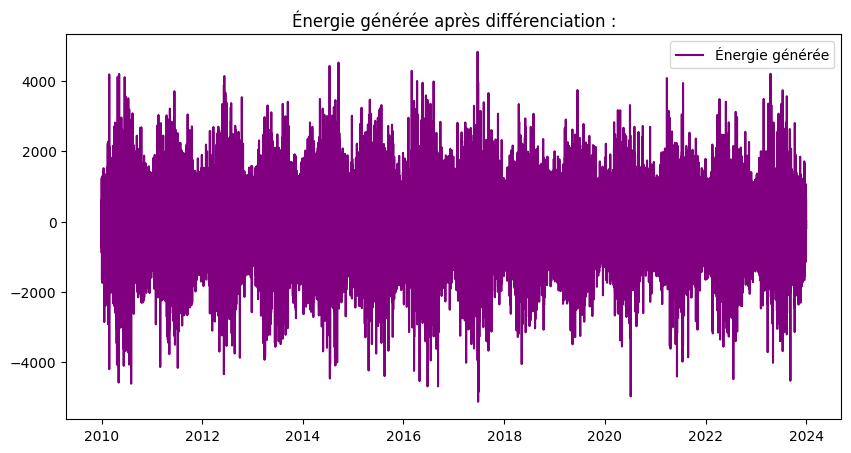

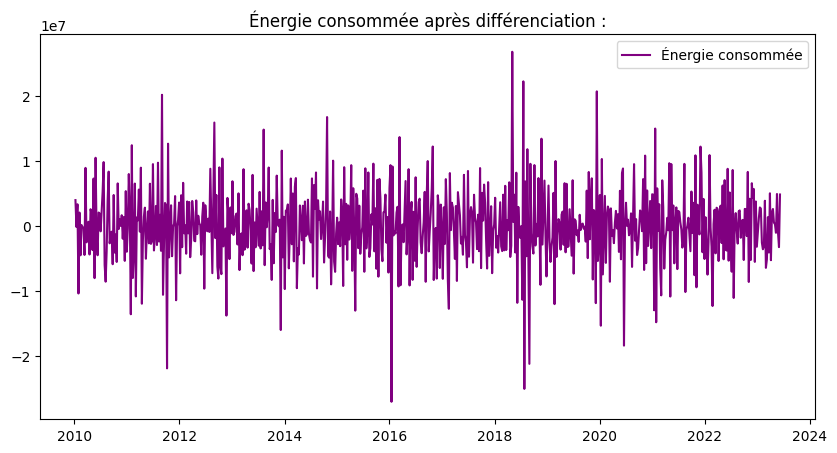

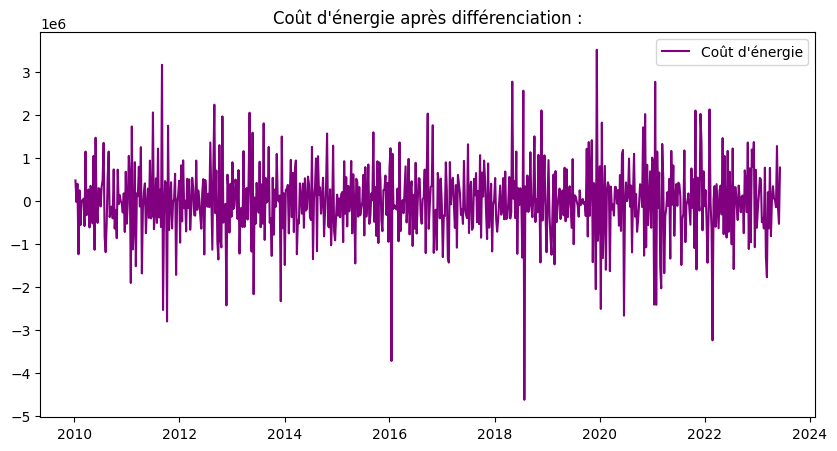

In [38]:
# Appliquer la diff√©renciation √† chaque s√©rie
differenced_series = {key: value.diff().dropna() for key, value in series.items()}

# Afficher un aper√ßu des s√©ries diff√©renci√©es
for name, data in differenced_series.items():
    # Tracer les estimations de la puissance AC au fil du temps
    plt.figure(figsize=(10, 5))
    plt.plot(data, label=name, color='Purple')  # Tracer la puissance AC estim√©e
    plt.title(f"{name} apr√®s diff√©renciation :")  # D√©finir le titre du graphique
    plt.legend()  # Afficher la l√©gende
    plt.show()

Apr√®s la diff√©renciation, on peut distinguer visuellement que les s√©ries sont clairement stationnaires, ce qui indique qu'elles ne l'√©taient pas auparavant.

## SARIMA

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustement d'un mod√®le SARIMA
# Ici, on utilise un ordre saisonnier (1, 1, 0, 52) pour une saisonnalit√© hebdomadaire (52 semaines/an)
# L'ordre (1, 1, 0) correspond respectivement √† l'ordre AR (autoregressive), I (int√©gration), MA (moyenne mobile)
model = SARIMAX(E_consumed, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))  # Ajuster les param√®tres si n√©cessaire

# Entra√Ænement du mod√®le sur les donn√©es
result = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


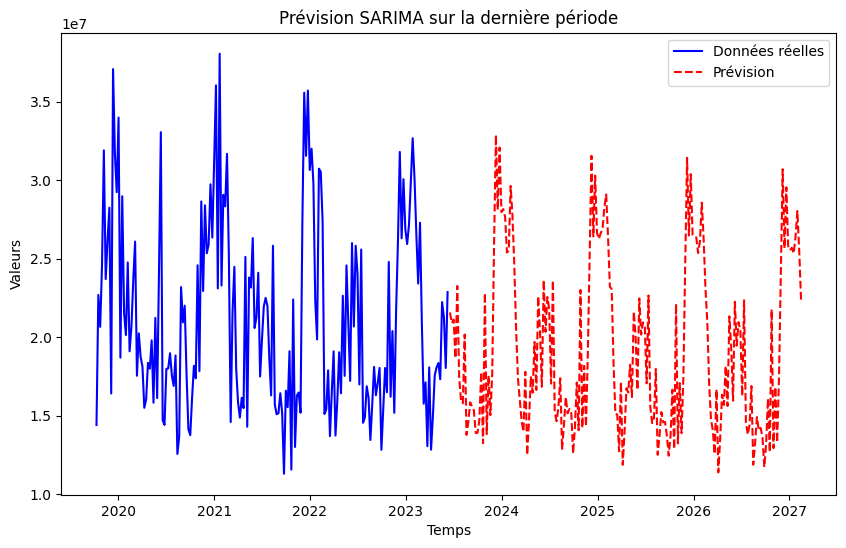

In [40]:
# √âtape 3 : Pr√©voir les 10 prochaines p√©riodes (ajustez le nombre de pas si n√©cessaire)
forecast_steps = 4 * 12 * 4  # Par exemple, l'ideal est la periode du serie 

# G√©n√©ration des pr√©visions
forecast = result.forecast(steps=forecast_steps)  # Pas de param√®tre alpha pour √©viter les avertissements

# Cr√©ation des indices temporels pour les pr√©visions
forecast_index = pd.date_range(start=E_consumed.index[-1], periods=forecast_steps + 1, freq='W')[1:]

# Affichage des donn√©es originales et des pr√©visions
plt.figure(figsize=(10, 6))

# Affichage des derni√®res donn√©es r√©elles (ex: dernier mois ou plus selon les pas)
plt.plot(E_consumed[-4*12*4:].index, E_consumed[-4*12*4:], label='Donn√©es r√©elles', color='blue')

# Affichage des pr√©visions
plt.plot(forecast_index, forecast, label='Pr√©vision', color='red', linestyle='dashed')

plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Pr√©vision SARIMA sur la derni√®re p√©riode')
plt.legend()

plt.show()


# Deep learning

Pour le deep learning, nous allons essayer d‚Äôutiliser un mod√®le LSTM ainsi que des Transformers afin de pr√©voir les s√©ries temporelles des jeux de donn√©es. Ces mod√®les sont particuli√®rement adapt√©s √† la mod√©lisation de donn√©es s√©quentielles et permettent de capturer des d√©pendances complexes dans le temps.

## Consumed Energy

Pour l‚Äô√©nergie consomm√©e, les mod√®les de deep learning ne vont pas tr√®s bien performer en raison de la petite taille du jeu de donn√©es.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [42]:
data = E_consumed.values.reshape(-1, 1)  # S'assurer que les donn√©es ont la bonne forme (colonne unique)
scaler = StandardScaler()  # Initialisation du standardiseur (moyenne = 0, √©cart-type = 1)
scaled_data = scaler.fit_transform(data)  # Normalisation des donn√©es

In [43]:
def create_sequences(data, time_steps=24):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Les time_steps pr√©c√©dents comme entr√©e
        Y.append(data[i+time_steps])    # La valeur suivante comme cible
    return np.array(X), np.array(Y)  # Conversion en tableaux NumPy

In [44]:
# D√©finir le nombre de pas de temps (52 semaines pour une saisonnalit√© annuelle)
time_steps = 52
X, Y = create_sequences(scaled_data, time_steps)

# Remodeler X pour qu'il soit compatible avec un LSTM (√©chantillons, pas de temps, caract√©ristiques)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [45]:
# Convertir les donn√©es en tenseurs (en supposant que X et Y sont ordonn√©s dans le temps)
X_tensor = torch.tensor(X, dtype=torch.float32)  # Caract√©ristiques
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Cibles

# D√©finir les indices de division (s√©quentiel, pas de m√©lange)
train_size = int(0.6 * len(X_tensor))  # Premier 60% pour l'entra√Ænement
val_size = int(0.2 * len(X_tensor))    # Suivant 20% pour la validation
# Les 20% restants pour les tests

# Diviser les donn√©es de mani√®re s√©quentielle
X_train, Y_train = X_tensor[:train_size], Y_tensor[:train_size]  # Entra√Ænement
X_val, Y_val = X_tensor[train_size : train_size + val_size], Y_tensor[train_size : train_size + val_size]  # Validation
X_test, Y_test = X_tensor[train_size + val_size :], Y_tensor[train_size + val_size :]  # Test

# Cr√©er des ensembles de donn√©es
train_dataset = TensorDataset(X_train, Y_train)  # Ensemble d'entra√Ænement
val_dataset = TensorDataset(X_val, Y_val)  # Ensemble de validation
test_dataset = TensorDataset(X_test, Y_test)  # Ensemble de test

# DataLoaders (shuffle=False pour tous pour pr√©server l'ordre temporel)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Pas de m√©lange !
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Pas de m√©lange !
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Pas de m√©lange !

# Afficher le nombre d'√©chantillons dans chaque ensemble
print(f"√âchantillons d'entra√Ænement : {len(X_train)}, √âchantillons de validation : {len(X_val)}, √âchantillons de test : {len(X_test)}")

√âchantillons d'entra√Ænement : 390, √âchantillons de validation : 130, √âchantillons de test : 130


### Mod√®le LSTM

Ce mod√®le **LSTM** (Long Short-Term Memory) est con√ßu pour traiter des s√©ries temporelles. Voici les principales caract√©ristiques :

- **LSTM** : Il est utilis√© pour apprendre des d√©pendances √† long terme dans les s√©quences de donn√©es. Il prend en compte les valeurs pass√©es pour - pr√©voir les valeurs futures.

- **Dropout** : Appliqu√© au LSTM et avant la couche finale pour √©viter le surapprentissage (overfitting).

- **Couche fully connected (FC) :** Cette couche dense prend la sortie du LSTM pour produire une pr√©diction finale. Elle est utilis√©e pour r√©duire la dimensionnalit√© et fournir la sortie attendue.

- **Activation ReLU :** Une fonction d'activation qui introduit de la non-lin√©arit√© dans le mod√®le.

Le mod√®le est structur√© pour accepter des donn√©es s√©quentielles, et il peut √™tre adapt√© √† divers probl√®mes de pr√©vision, comme les s√©ries temporelles.

In [46]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2, weight_decay=1e-5):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Ajouter du dropout au LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)

        # Ajouter du dropout avant la couche finale
        self.dropout = nn.Dropout(dropout)

        # Couche fully connected (dense) pour la sortie
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialiser l'√©tat cach√© avec des z√©ros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Passer les donn√©es √† travers le LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Appliquer le dropout avant la couche finale
        out = self.dropout(out[:, -1, :])
        out = F.relu(out)  # Appliquer la fonction ReLU
        out = self.fc(out)    # Passer par la couche fully connected
        return out

# Cr√©er le mod√®le
model = LSTM(1, 128, 2, dropout=0.2).to(device)

In [47]:
# Premi√®rement, ajoutez ces variables au d√©but de votre script (en dehors des fonctions)
# Variables globales pour stocker les pertes
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')

def train_one_epoch(epoch):
    model.train()
    epoch_loss = 0.0

    # Barre principale pour l'entra√Ænement
    with tqdm(train_loader, unit="batch", leave=False,
              desc=f"Epoch {epoch+1}/{num_epochs} [Train]") as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward + backward
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # M√†J des m√©triques
            batch_loss = loss.item()
            epoch_loss += batch_loss
            avg_loss = epoch_loss / (pbar.n + 1)

            # Affichage dans la barre
            pbar.set_postfix({
                "loss": f"{batch_loss:.4f}",
                "avg": f"{avg_loss:.4f}"
            })

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    tqdm.write(f"[Train] Epoch {epoch+1} ‚Äì avg loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


def validate_one_epoch(epoch):
    global best_val_loss
    model.eval()
    running_loss = 0.0
    all_targets, all_preds = [], []

    # Barre principale pour la validation
    with tqdm(val_loader, unit="batch", leave=False,
              desc=f"Epoch {epoch+1}/{num_epochs} [Val]") as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                outputs = model(x_batch)
                loss = loss_function(outputs, y_batch)

            # Collecte pour m√©triques finales
            all_targets.append(y_batch.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())

            batch_loss = loss.item()
            running_loss += batch_loss
            avg_loss = running_loss / (pbar.n + 1)
            pbar.set_postfix({"loss": f"{avg_loss:.4f}"})

    avg_val_loss = running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    targets = np.concatenate(all_targets)
    preds = np.concatenate(all_preds)
    val_mae = np.mean(np.abs(preds - targets))
    val_rmse = np.sqrt(np.mean((preds - targets)**2))

    # Sauvegarde du meilleur mod√®le
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_loss': best_val_loss,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
        }, 'best_model.pth')
        tqdm.write(
            f"[Val] Epoch {epoch+1} ‚Äì Nouvelle meilleure performance ! "
            f"loss={avg_val_loss:.4f}, MAE={val_mae:.4f}, RMSE={val_rmse:.4f}"
        )
    else:
        tqdm.write(
            f"[Val] Epoch {epoch+1} ‚Äì loss={avg_val_loss:.4f} "
            f"(best={best_val_loss:.4f}), MAE={val_mae:.4f}, RMSE={val_rmse:.4f}"
        )
    return avg_val_loss


def train_and_validate():
    for epoch in range(num_epochs):
        train_one_epoch(epoch)
        validate_one_epoch(epoch)

def test_model():
    """Final evaluation on test set using best model"""
    # Load best model
    model.load_state_dict(torch.load('best_model.pth', weights_only=True)['model_state_dict'])
    model.eval()
    
    test_loss = 0.0
    all_preds = []
    all_targets = []

    # Inference with progress bar
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Testing", unit="batch"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            
            loss = loss_function(outputs, y_batch)
            test_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    # Calculate metrics
    avg_loss = test_loss / len(test_loader)
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    
    metrics = {
        'loss': avg_loss,
        'mae': np.mean(np.abs(preds - targets)),
        'rmse': np.sqrt(np.mean((preds - targets)**2)),
        'R2': 1 - np.sum((targets - preds) ** 2) / np.sum((targets - np.mean(targets)) ** 2)
    }


    # Print results
    print("\n" + "="*40)
    print("FINAL TEST RESULTS")
    print("="*40)
    print(f"{'Loss:':<10}{metrics['loss']:.4f}")
    print(f"{'MAE:':<10}{metrics['mae']:.4f}")
    print(f"{'RMSE:':<10}{metrics['rmse']:.4f}")
    print(f"{'R¬≤:':<10}{metrics['R2']:.4f}")
    print("="*40)

    # Plot last 100 points
    plt.figure(figsize=(12,5))
    plt.plot(targets[-100:], label='True', alpha=0.7)
    plt.plot(preds[-100:], label='Predicted', linestyle='--')
    plt.title("Test Predictions (Last 100 Points)")
    plt.legend()
    plt.show()

    return metrics

def plot_losses():
    """
    Tracer les pertes d'entra√Ænement et de validation.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def reset_losses():
    train_losses.clear()
    val_losses.clear()
    test_losses.clear()

In [48]:
reset_losses()

model = LSTM(1, 128, 2, dropout=0.3).to(device)
learning_rate = 0.0005
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses = []
val_losses = []
test_losses = []

best_val_loss = float('inf')
train_and_validate()

print("\nTraining completed!")

[Train] Epoch 1 ‚Äì avg loss: 1.6845


[Val] Epoch 1 ‚Äì Nouvelle meilleure performance ! loss=0.9199, MAE=0.7998, RMSE=1.0383


[Train] Epoch 2 ‚Äì avg loss: 1.6074


[Val] Epoch 2 ‚Äì Nouvelle meilleure performance ! loss=0.8408, MAE=0.7694, RMSE=0.9922


[Train] Epoch 3 ‚Äì avg loss: 1.4439


[Val] Epoch 3 ‚Äì Nouvelle meilleure performance ! loss=0.6883, MAE=0.7112, RMSE=0.8943


[Train] Epoch 4 ‚Äì avg loss: 1.2139


[Val] Epoch 4 ‚Äì Nouvelle meilleure performance ! loss=0.5414, MAE=0.6354, RMSE=0.8109


[Train] Epoch 5 ‚Äì avg loss: 1.0081


[Val] Epoch 5 ‚Äì Nouvelle meilleure performance ! loss=0.4966, MAE=0.5887, RMSE=0.7815


[Train] Epoch 6 ‚Äì avg loss: 0.9690


[Val] Epoch 6 ‚Äì Nouvelle meilleure performance ! loss=0.4859, MAE=0.5946, RMSE=0.7718


[Train] Epoch 7 ‚Äì avg loss: 0.9052


[Val] Epoch 7 ‚Äì Nouvelle meilleure performance ! loss=0.4783, MAE=0.5704, RMSE=0.7629


[Train] Epoch 8 ‚Äì avg loss: 0.8409


[Val] Epoch 8 ‚Äì loss=0.5152 (best=0.4783), MAE=0.5930, RMSE=0.7782


[Train] Epoch 9 ‚Äì avg loss: 0.7749


[Val] Epoch 9 ‚Äì loss=0.5071 (best=0.4783), MAE=0.5727, RMSE=0.7778


[Train] Epoch 10 ‚Äì avg loss: 0.8212


[Val] Epoch 10 ‚Äì loss=0.5919 (best=0.4783), MAE=0.6044, RMSE=0.8084


[Train] Epoch 11 ‚Äì avg loss: 0.7995


[Val] Epoch 11 ‚Äì loss=0.5508 (best=0.4783), MAE=0.5808, RMSE=0.7922


[Train] Epoch 12 ‚Äì avg loss: 0.7634


[Val] Epoch 12 ‚Äì loss=0.5943 (best=0.4783), MAE=0.5991, RMSE=0.8235


[Train] Epoch 13 ‚Äì avg loss: 0.8071


[Val] Epoch 13 ‚Äì loss=0.6045 (best=0.4783), MAE=0.6135, RMSE=0.8348


[Train] Epoch 14 ‚Äì avg loss: 0.8171


[Val] Epoch 14 ‚Äì loss=0.6434 (best=0.4783), MAE=0.6169, RMSE=0.8437


[Train] Epoch 15 ‚Äì avg loss: 0.7571


[Val] Epoch 15 ‚Äì loss=0.6356 (best=0.4783), MAE=0.6105, RMSE=0.8382


[Train] Epoch 16 ‚Äì avg loss: 0.7567


[Val] Epoch 16 ‚Äì loss=0.6668 (best=0.4783), MAE=0.6213, RMSE=0.8517


[Train] Epoch 17 ‚Äì avg loss: 0.7042


[Val] Epoch 17 ‚Äì loss=0.6885 (best=0.4783), MAE=0.6315, RMSE=0.8654


[Train] Epoch 18 ‚Äì avg loss: 0.7124


[Val] Epoch 18 ‚Äì loss=0.6625 (best=0.4783), MAE=0.6360, RMSE=0.8603


[Train] Epoch 19 ‚Äì avg loss: 0.7107


[Val] Epoch 19 ‚Äì loss=0.7210 (best=0.4783), MAE=0.6397, RMSE=0.8725


[Train] Epoch 20 ‚Äì avg loss: 0.6903


[Val] Epoch 20 ‚Äì loss=0.6882 (best=0.4783), MAE=0.6367, RMSE=0.8806


[Train] Epoch 21 ‚Äì avg loss: 0.7045


[Val] Epoch 21 ‚Äì loss=0.7128 (best=0.4783), MAE=0.6367, RMSE=0.8722


[Train] Epoch 22 ‚Äì avg loss: 0.6777


[Val] Epoch 22 ‚Äì loss=0.6103 (best=0.4783), MAE=0.6168, RMSE=0.8474


[Train] Epoch 23 ‚Äì avg loss: 0.7763


[Val] Epoch 23 ‚Äì loss=0.7478 (best=0.4783), MAE=0.6583, RMSE=0.9007


[Train] Epoch 24 ‚Äì avg loss: 0.7179


[Val] Epoch 24 ‚Äì loss=0.6972 (best=0.4783), MAE=0.6412, RMSE=0.8840


[Train] Epoch 25 ‚Äì avg loss: 0.6783


[Val] Epoch 25 ‚Äì loss=0.6837 (best=0.4783), MAE=0.6358, RMSE=0.8704


[Train] Epoch 26 ‚Äì avg loss: 0.6779


[Val] Epoch 26 ‚Äì loss=0.7317 (best=0.4783), MAE=0.6496, RMSE=0.8885


[Train] Epoch 27 ‚Äì avg loss: 0.6463


[Val] Epoch 27 ‚Äì loss=0.7479 (best=0.4783), MAE=0.6598, RMSE=0.9101


[Train] Epoch 28 ‚Äì avg loss: 0.6771


[Val] Epoch 28 ‚Äì loss=0.7779 (best=0.4783), MAE=0.6644, RMSE=0.9089


[Train] Epoch 29 ‚Äì avg loss: 0.6546


[Val] Epoch 29 ‚Äì loss=0.7591 (best=0.4783), MAE=0.6617, RMSE=0.8996


[Train] Epoch 30 ‚Äì avg loss: 0.6160


[Val] Epoch 30 ‚Äì loss=0.7747 (best=0.4783), MAE=0.6711, RMSE=0.9158


[Train] Epoch 31 ‚Äì avg loss: 0.5995


[Val] Epoch 31 ‚Äì loss=0.8260 (best=0.4783), MAE=0.6925, RMSE=0.9348


[Train] Epoch 32 ‚Äì avg loss: 0.6082


[Val] Epoch 32 ‚Äì loss=0.8952 (best=0.4783), MAE=0.7124, RMSE=0.9566


[Train] Epoch 33 ‚Äì avg loss: 0.6092


[Val] Epoch 33 ‚Äì loss=0.8883 (best=0.4783), MAE=0.7238, RMSE=0.9702


[Train] Epoch 34 ‚Äì avg loss: 0.6172


[Val] Epoch 34 ‚Äì loss=0.7755 (best=0.4783), MAE=0.6896, RMSE=0.9344


[Train] Epoch 35 ‚Äì avg loss: 0.6214


[Val] Epoch 35 ‚Äì loss=0.7472 (best=0.4783), MAE=0.6735, RMSE=0.9053


[Train] Epoch 36 ‚Äì avg loss: 0.6095


[Val] Epoch 36 ‚Äì loss=0.8167 (best=0.4783), MAE=0.6891, RMSE=0.9382


[Train] Epoch 37 ‚Äì avg loss: 0.6618


[Val] Epoch 37 ‚Äì loss=0.8004 (best=0.4783), MAE=0.6850, RMSE=0.9353


[Train] Epoch 38 ‚Äì avg loss: 0.5752


[Val] Epoch 38 ‚Äì loss=0.8781 (best=0.4783), MAE=0.7084, RMSE=0.9635


[Train] Epoch 39 ‚Äì avg loss: 0.5583


[Val] Epoch 39 ‚Äì loss=0.8970 (best=0.4783), MAE=0.7153, RMSE=0.9646


[Train] Epoch 40 ‚Äì avg loss: 0.6403


[Val] Epoch 40 ‚Äì loss=0.7653 (best=0.4783), MAE=0.6763, RMSE=0.9212


[Train] Epoch 41 ‚Äì avg loss: 0.6104


[Val] Epoch 41 ‚Äì loss=0.7877 (best=0.4783), MAE=0.6853, RMSE=0.9383


[Train] Epoch 42 ‚Äì avg loss: 0.6393


[Val] Epoch 42 ‚Äì loss=0.8161 (best=0.4783), MAE=0.6899, RMSE=0.9436


[Train] Epoch 43 ‚Äì avg loss: 0.6409


[Val] Epoch 43 ‚Äì loss=0.8372 (best=0.4783), MAE=0.6928, RMSE=0.9342


[Train] Epoch 44 ‚Äì avg loss: 0.5682


[Val] Epoch 44 ‚Äì loss=0.7984 (best=0.4783), MAE=0.6958, RMSE=0.9306


[Train] Epoch 45 ‚Äì avg loss: 0.6137


[Val] Epoch 45 ‚Äì loss=0.8638 (best=0.4783), MAE=0.7188, RMSE=0.9732


[Train] Epoch 46 ‚Äì avg loss: 0.6268


[Val] Epoch 46 ‚Äì loss=0.7878 (best=0.4783), MAE=0.6963, RMSE=0.9363


[Train] Epoch 47 ‚Äì avg loss: 0.5695


[Val] Epoch 47 ‚Äì loss=0.8755 (best=0.4783), MAE=0.7214, RMSE=0.9796


[Train] Epoch 48 ‚Äì avg loss: 0.5323


[Val] Epoch 48 ‚Äì loss=0.9698 (best=0.4783), MAE=0.7546, RMSE=1.0232


[Train] Epoch 49 ‚Äì avg loss: 0.5115


[Val] Epoch 49 ‚Äì loss=0.9199 (best=0.4783), MAE=0.7364, RMSE=0.9983


[Train] Epoch 50 ‚Äì avg loss: 0.6093


[Val] Epoch 50 ‚Äì loss=0.8723 (best=0.4783), MAE=0.7160, RMSE=0.9747


[Train] Epoch 51 ‚Äì avg loss: 0.6137


[Val] Epoch 51 ‚Äì loss=0.8811 (best=0.4783), MAE=0.7216, RMSE=0.9786


[Train] Epoch 52 ‚Äì avg loss: 0.5264


[Val] Epoch 52 ‚Äì loss=0.7410 (best=0.4783), MAE=0.6788, RMSE=0.9020


[Train] Epoch 53 ‚Äì avg loss: 0.6975


[Val] Epoch 53 ‚Äì loss=0.8145 (best=0.4783), MAE=0.6795, RMSE=0.9250


[Train] Epoch 54 ‚Äì avg loss: 0.5795


[Val] Epoch 54 ‚Äì loss=0.8034 (best=0.4783), MAE=0.6879, RMSE=0.9308


[Train] Epoch 55 ‚Äì avg loss: 0.5980


[Val] Epoch 55 ‚Äì loss=0.8464 (best=0.4783), MAE=0.7058, RMSE=0.9543


[Train] Epoch 56 ‚Äì avg loss: 0.5401


[Val] Epoch 56 ‚Äì loss=0.9106 (best=0.4783), MAE=0.7141, RMSE=0.9625


[Train] Epoch 57 ‚Äì avg loss: 0.5464


[Val] Epoch 57 ‚Äì loss=0.8675 (best=0.4783), MAE=0.7183, RMSE=0.9717


[Train] Epoch 58 ‚Äì avg loss: 0.5395


[Val] Epoch 58 ‚Äì loss=0.8505 (best=0.4783), MAE=0.7254, RMSE=0.9799


[Train] Epoch 59 ‚Äì avg loss: 0.5817


[Val] Epoch 59 ‚Äì loss=0.7818 (best=0.4783), MAE=0.6884, RMSE=0.9347


[Train] Epoch 60 ‚Äì avg loss: 0.5298


[Val] Epoch 60 ‚Äì loss=0.8308 (best=0.4783), MAE=0.7044, RMSE=0.9504


[Train] Epoch 61 ‚Äì avg loss: 0.5106


[Val] Epoch 61 ‚Äì loss=0.9553 (best=0.4783), MAE=0.7503, RMSE=1.0181


[Train] Epoch 62 ‚Äì avg loss: 0.5208


[Val] Epoch 62 ‚Äì loss=0.8685 (best=0.4783), MAE=0.7133, RMSE=0.9612


[Train] Epoch 63 ‚Äì avg loss: 0.5056


[Val] Epoch 63 ‚Äì loss=0.9097 (best=0.4783), MAE=0.7219, RMSE=0.9774


[Train] Epoch 64 ‚Äì avg loss: 0.5280


[Val] Epoch 64 ‚Äì loss=0.9386 (best=0.4783), MAE=0.7497, RMSE=1.0125


[Train] Epoch 65 ‚Äì avg loss: 0.5326


[Val] Epoch 65 ‚Äì loss=1.0118 (best=0.4783), MAE=0.7716, RMSE=1.0440


[Train] Epoch 66 ‚Äì avg loss: 0.5299


[Val] Epoch 66 ‚Äì loss=0.9077 (best=0.4783), MAE=0.7330, RMSE=0.9874


[Train] Epoch 67 ‚Äì avg loss: 0.4841


[Val] Epoch 67 ‚Äì loss=0.9335 (best=0.4783), MAE=0.7314, RMSE=0.9913


[Train] Epoch 68 ‚Äì avg loss: 0.4875


[Val] Epoch 68 ‚Äì loss=0.9353 (best=0.4783), MAE=0.7386, RMSE=1.0047


[Train] Epoch 69 ‚Äì avg loss: 0.5278


[Val] Epoch 69 ‚Äì loss=0.8389 (best=0.4783), MAE=0.7231, RMSE=0.9803


[Train] Epoch 70 ‚Äì avg loss: 0.5594


[Val] Epoch 70 ‚Äì loss=0.9528 (best=0.4783), MAE=0.7173, RMSE=0.9692


[Train] Epoch 71 ‚Äì avg loss: 0.5810


[Val] Epoch 71 ‚Äì loss=0.8854 (best=0.4783), MAE=0.7087, RMSE=0.9543


[Train] Epoch 72 ‚Äì avg loss: 0.4891


[Val] Epoch 72 ‚Äì loss=0.8828 (best=0.4783), MAE=0.7256, RMSE=0.9708


[Train] Epoch 73 ‚Äì avg loss: 0.4954


[Val] Epoch 73 ‚Äì loss=1.0086 (best=0.4783), MAE=0.7710, RMSE=1.0463


[Train] Epoch 74 ‚Äì avg loss: 0.4359


[Val] Epoch 74 ‚Äì loss=1.0186 (best=0.4783), MAE=0.7817, RMSE=1.0537


[Train] Epoch 75 ‚Äì avg loss: 0.4676


[Val] Epoch 75 ‚Äì loss=0.9521 (best=0.4783), MAE=0.7478, RMSE=1.0085


[Train] Epoch 76 ‚Äì avg loss: 0.5533


[Val] Epoch 76 ‚Äì loss=1.0236 (best=0.4783), MAE=0.7828, RMSE=1.0528


[Train] Epoch 77 ‚Äì avg loss: 0.5472


[Val] Epoch 77 ‚Äì loss=0.7697 (best=0.4783), MAE=0.6955, RMSE=0.9322


[Train] Epoch 78 ‚Äì avg loss: 0.5216


[Val] Epoch 78 ‚Äì loss=0.7700 (best=0.4783), MAE=0.7095, RMSE=0.9530


[Train] Epoch 79 ‚Äì avg loss: 0.4951


[Val] Epoch 79 ‚Äì loss=1.0066 (best=0.4783), MAE=0.7833, RMSE=1.0333


[Train] Epoch 80 ‚Äì avg loss: 0.4972


[Val] Epoch 80 ‚Äì loss=0.9615 (best=0.4783), MAE=0.7474, RMSE=0.9981


[Train] Epoch 81 ‚Äì avg loss: 0.5464


[Val] Epoch 81 ‚Äì loss=0.8165 (best=0.4783), MAE=0.7100, RMSE=0.9659


[Train] Epoch 82 ‚Äì avg loss: 0.4357


[Val] Epoch 82 ‚Äì loss=0.9574 (best=0.4783), MAE=0.7543, RMSE=1.0222


[Train] Epoch 83 ‚Äì avg loss: 0.4411


[Val] Epoch 83 ‚Äì loss=1.0067 (best=0.4783), MAE=0.7860, RMSE=1.0616


[Train] Epoch 84 ‚Äì avg loss: 0.4240


[Val] Epoch 84 ‚Äì loss=0.9819 (best=0.4783), MAE=0.7798, RMSE=1.0532


[Train] Epoch 85 ‚Äì avg loss: 0.4470


[Val] Epoch 85 ‚Äì loss=0.8441 (best=0.4783), MAE=0.7247, RMSE=0.9882


[Train] Epoch 86 ‚Äì avg loss: 0.4272


[Val] Epoch 86 ‚Äì loss=1.0271 (best=0.4783), MAE=0.7563, RMSE=1.0283


[Train] Epoch 87 ‚Äì avg loss: 0.4340


[Val] Epoch 87 ‚Äì loss=0.9194 (best=0.4783), MAE=0.7595, RMSE=1.0277


[Train] Epoch 88 ‚Äì avg loss: 0.4121


[Val] Epoch 88 ‚Äì loss=1.0465 (best=0.4783), MAE=0.7824, RMSE=1.0605


[Train] Epoch 89 ‚Äì avg loss: 0.4165


[Val] Epoch 89 ‚Äì loss=0.9896 (best=0.4783), MAE=0.7538, RMSE=1.0305


[Train] Epoch 90 ‚Äì avg loss: 0.4235


[Val] Epoch 90 ‚Äì loss=1.0107 (best=0.4783), MAE=0.7739, RMSE=1.0449


[Train] Epoch 91 ‚Äì avg loss: 0.4191


[Val] Epoch 91 ‚Äì loss=0.9531 (best=0.4783), MAE=0.7599, RMSE=1.0113


[Train] Epoch 92 ‚Äì avg loss: 0.3987


[Val] Epoch 92 ‚Äì loss=1.0359 (best=0.4783), MAE=0.7875, RMSE=1.0688


[Train] Epoch 93 ‚Äì avg loss: 0.4100


[Val] Epoch 93 ‚Äì loss=1.0257 (best=0.4783), MAE=0.7905, RMSE=1.0786


[Train] Epoch 94 ‚Äì avg loss: 0.3907


[Val] Epoch 94 ‚Äì loss=0.9224 (best=0.4783), MAE=0.7666, RMSE=1.0444


[Train] Epoch 95 ‚Äì avg loss: 0.4147


[Val] Epoch 95 ‚Äì loss=0.9895 (best=0.4783), MAE=0.7736, RMSE=1.0499


[Train] Epoch 96 ‚Äì avg loss: 0.4018


[Val] Epoch 96 ‚Äì loss=1.0762 (best=0.4783), MAE=0.8070, RMSE=1.1073


[Train] Epoch 97 ‚Äì avg loss: 0.4155


[Val] Epoch 97 ‚Äì loss=0.9670 (best=0.4783), MAE=0.7770, RMSE=1.0565


[Train] Epoch 98 ‚Äì avg loss: 0.4096


[Val] Epoch 98 ‚Äì loss=1.0639 (best=0.4783), MAE=0.7985, RMSE=1.0681


[Train] Epoch 99 ‚Äì avg loss: 0.4429


[Val] Epoch 99 ‚Äì loss=1.1045 (best=0.4783), MAE=0.8202, RMSE=1.1249


[Train] Epoch 100 ‚Äì avg loss: 0.4576


[Val] Epoch 100 ‚Äì loss=0.8604 (best=0.4783), MAE=0.7434, RMSE=0.9996

Training completed!


Running final evaluation...


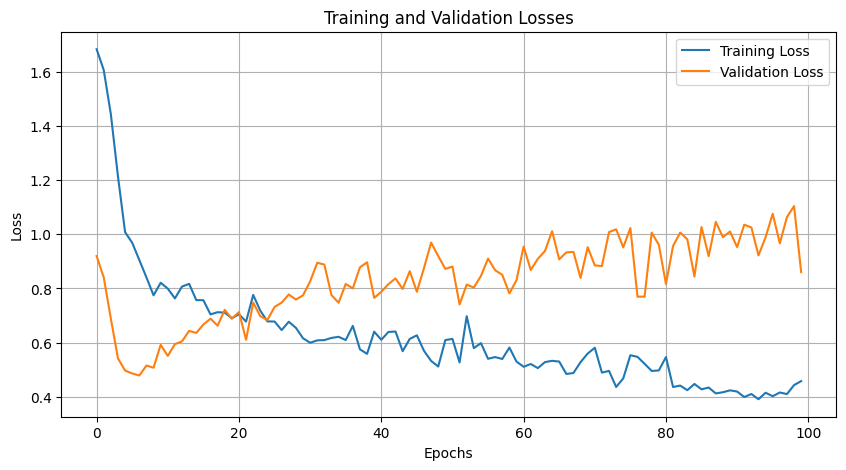

/tmp/ipykernel_31/3105391348.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
Testing: 100%|‚ñà‚


FINAL TEST RESULTS
Loss:     0.3970
MAE:      0.5409
RMSE:     0.6823
R¬≤:       0.4364


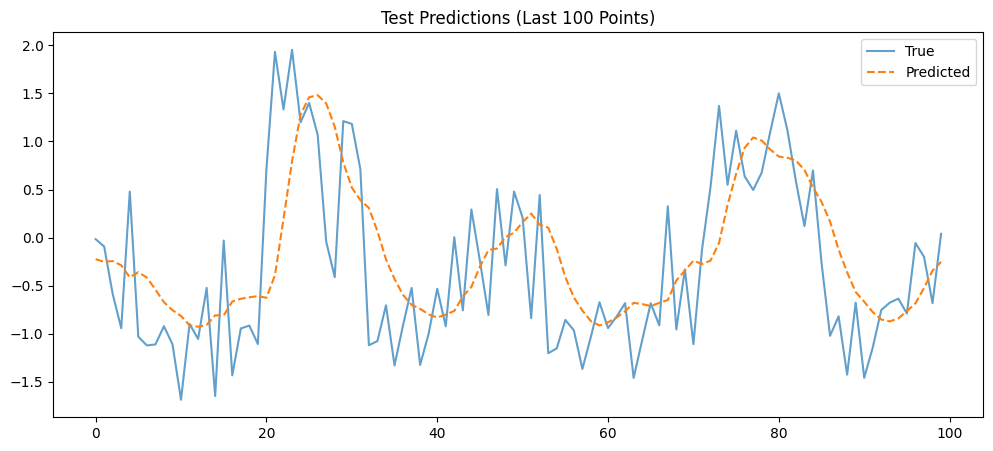

In [49]:
print("Running final evaluation...")
# 1. Tracer les courbes d'apprentissage
plot_losses()

# 2. √âvaluation finale sur le test set
test_results = test_model()

In [50]:
with torch.no_grad():

    predicted = model(X_train.to(device)).to('cpu').numpy()

train_predictions_normalized = predicted.flatten()
train_predictions = scaler.inverse_transform(train_predictions_normalized.reshape(-1, 1))

Y_train_unnormalized= scaler.inverse_transform(Y_train.reshape(-1, 1))

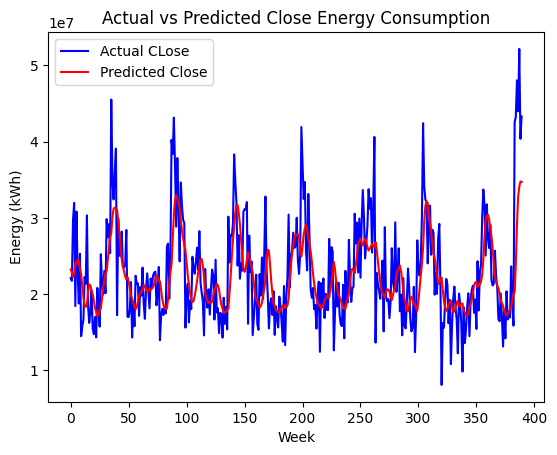

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [51]:
plt.plot(Y_train_unnormalized, label='Actual CLose', color='blue')
plt.plot(train_predictions, label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))

In [52]:
# Get predictions from the model
test_predictions_tensor = model(X_test.to(device)).detach().cpu()

# Convert the tensor to a NumPy array
test_predictions_normalized = test_predictions_tensor.numpy().flatten()

# Inverse transform the scaled predictions
test_predictions = scaler.inverse_transform(test_predictions_normalized.reshape(-1, 1))

Y_test_unnormalized = scaler.inverse_transform(Y_test.reshape(-1, 1))

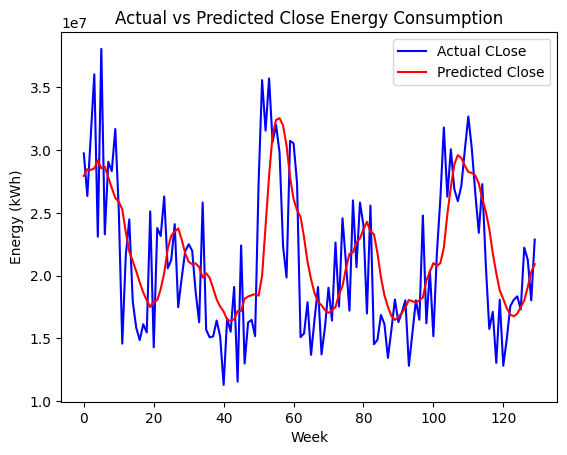

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [53]:
plt.plot(Y_test_unnormalized, label='Actual CLose', color='blue')
plt.plot(test_predictions, label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))

In [54]:
def predict_and_plot_future(
    model,
    series,
    window_size,
    future_steps,
    scaler=None,
    device='cpu',
    datetime_col=None,
    freq='D',  # Change this to 'H', 'M', 'MS', '30min', etc. depending on your time series
    title='Forecast'
):
    """
    Predict and plot future time steps using an LSTM model.

    Args:
        model: Trained PyTorch LSTM model.
        series: 1D pandas Series or array of the full historical time series.
        window_size: Size of the input window.
        future_steps: Number of future steps to predict.
        scaler: Scaler used during training (optional).
        device: Device to run the model on.
        datetime_col: Optional datetime index if using pandas Series with a time index.
        freq: Frequency of the time series (used to extend the index).
        title: Title for the plot.
    """
    model.eval()

    # Use the last window for rolling prediction
    history = list(series[-window_size:])
    predictions = []

    for _ in range(future_steps):
        input_seq = np.array(history[-window_size:]).reshape(1, window_size, 1)

        if scaler:
            input_seq = scaler.transform(input_seq.reshape(-1, 1)).reshape(1, window_size, 1)

        input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)

        with torch.no_grad():
            pred = model(input_tensor).cpu().item()

        if scaler:
            pred = scaler.inverse_transform([[pred]])[0][0]

        predictions.append(pred)
        history.append(pred)

    # Handle historical and future time indices
    if isinstance(series, pd.Series) and isinstance(series.index, pd.DatetimeIndex):
        historical_index = series.index

        # Try to infer frequency if it's not set
        freq_inferred = series.index.freq or pd.infer_freq(series.index)
        if freq_inferred is None:
            raise ValueError("Could not infer frequency from the time index. Please pass `freq='W'` manually.")

        future_index = pd.date_range(
            start=historical_index[-1] + pd.tseries.frequencies.to_offset(freq_inferred),
            periods=future_steps,
            freq=freq_inferred
        )
    else:
        # No datetime index, use fallback
        start = pd.to_datetime('2023-01-01') if datetime_col is None else pd.to_datetime(datetime_col)
        historical_index = pd.date_range(start=start, periods=len(series), freq=freq)
        future_index = pd.date_range(start=historical_index[-1] + pd.tseries.frequencies.to_offset(freq), periods=future_steps, freq=freq)


    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(historical_index[-52*4:], series[-52*4:], label='Historical', linewidth=2)
    plt.plot(future_index, predictions, label='Forecast', linewidth=2, linestyle='--', color='orange')
    plt.axvline(x=historical_index[-1], color='gray', linestyle=':', label='Forecast Start')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return predictions


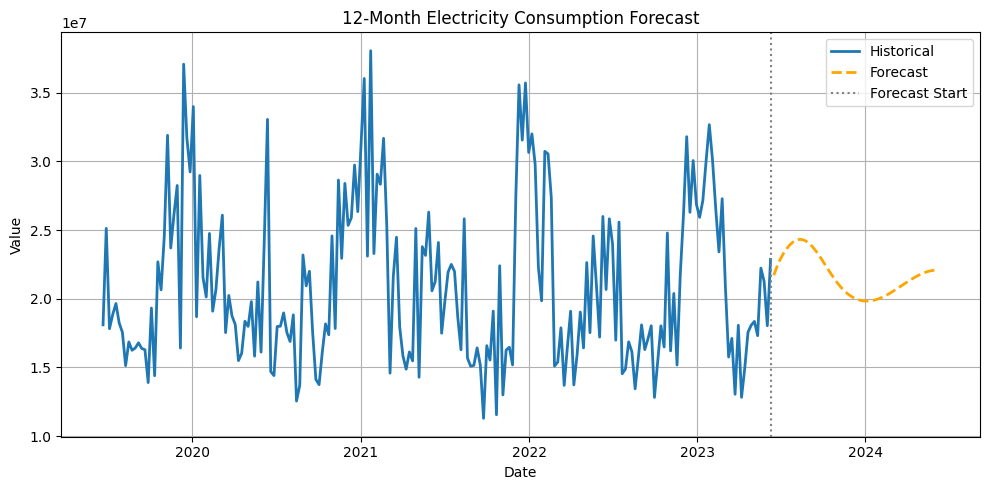

[21712106.808582492,
 22348152.188168462,
 22865848.07766954,
 23295102.99758561,
 23648321.59159797,
 23928509.970721338,
 24135945.125399698,
 24268512.691911988,
 24323688.268716432,
 24299979.845936872,
 24199104.344492033,
 24026616.767251942,
 23790512.851720553,
 23501518.555537663,
 23172468.10247587,
 22817122.274832793,
 22449082.3554917,
 22080934.02902809,
 21723336.067155328,
 21384731.892807595,
 21071363.137277756,
 20792688.659372024,
 20547993.0420541,
 20340788.596125185,
 20175591.935161877,
 20043417.813033387,
 19944096.496872924,
 19876642.176590797,
 19839295.74795274,
 19829957.441465348,
 19847011.89604067,
 19888369.33823164,
 19954755.680923194,
 20041908.60995753,
 20147411.081330523,
 20268224.696797784,
 20401685.909852542,
 20545342.69032849,
 20694140.43743521,
 20849481.796394613,
 21007940.32244353,
 21164520.791306783,
 21317132.42993266,
 21462197.553376935,
 21597528.526898902,
 21720459.504901122,
 21828650.362956036,
 21922571.914846085,
 21997787

In [56]:
# Assume you have a trained model, and last known sequence
last_known = E_consumed.values  # Replace with your actual series
future_steps = 52

# Example with a pandas Series that has a DateTimeIndex
predict_and_plot_future(
    model=model,
    series=E_consumed,     # Replace with your series
    window_size=time_steps,
    future_steps=future_steps,
    scaler=scaler,                    # Pass if you used MinMaxScaler or similar
    device=device,
    freq='W',
    title='12-Month Electricity Consumption Forecast'
)

## Generated Energy

En raison de la taille tr√®s importante des donn√©es (130k points~), nous allons d'abord en utiliser une portion pour trouver un bon mod√®le, puis nous l'entra√Ænerons sur l'ensemble des donn√©es par la suite.

In [58]:
E_generated_portion = E_generated['2022':'2023']
print(E_generated_portion)

Datetime
2022-01-01 00:00:00      0.000000
2022-01-01 01:00:00      0.000000
2022-01-01 02:00:00      0.000000
2022-01-01 03:00:00      0.000000
2022-01-01 04:00:00      0.000000
                          ...    
2023-12-31 19:00:00    309.072578
2023-12-31 20:00:00     94.076326
2023-12-31 21:00:00     21.791246
2023-12-31 22:00:00      0.000000
2023-12-31 23:00:00      0.000000
Length: 17520, dtype: float64


En suivant la m√™me approche

In [59]:
data = E_generated_portion.values.reshape(-1,1)  # Ensure data is in the right shape
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [61]:
# D√©finir le nombre de pas de temps (52 semaines pour une saisonnalit√© annuelle)
time_steps = 24*30
X, Y = create_sequences(scaled_data, time_steps)

# Remodeler X pour qu'il soit compatible avec un LSTM (√©chantillons, pas de temps, caract√©ristiques)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [62]:
# Convertir les donn√©es en tenseurs (en supposant que X et Y sont ordonn√©s dans le temps)
X_tensor = torch.tensor(X, dtype=torch.float32)  # Caract√©ristiques
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Cibles

# D√©finir les indices de division (s√©quentiel, pas de m√©lange)
train_size = int(0.6 * len(X_tensor))  # Premier 60% pour l'entra√Ænement
val_size = int(0.2 * len(X_tensor))    # Suivant 20% pour la validation
# Les 20% restants pour les tests

# Diviser les donn√©es de mani√®re s√©quentielle
X_train, Y_train = X_tensor[:train_size], Y_tensor[:train_size]  # Entra√Ænement
X_val, Y_val = X_tensor[train_size : train_size + val_size], Y_tensor[train_size : train_size + val_size]  # Validation
X_test, Y_test = X_tensor[train_size + val_size :], Y_tensor[train_size + val_size :]  # Test

# Cr√©er des ensembles de donn√©es
train_dataset = TensorDataset(X_train, Y_train)  # Ensemble d'entra√Ænement
val_dataset = TensorDataset(X_val, Y_val)  # Ensemble de validation
test_dataset = TensorDataset(X_test, Y_test)  # Ensemble de test

# DataLoaders (shuffle=False pour tous pour pr√©server l'ordre temporel)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Pas de m√©lange !
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Pas de m√©lange !
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Pas de m√©lange !

# Afficher le nombre d'√©chantillons dans chaque ensemble
print(f"√âchantillons d'entra√Ænement : {len(X_train)}, √âchantillons de validation : {len(X_val)}, √âchantillons de test : {len(X_test)}")

√âchantillons d'entra√Ænement : 10080, √âchantillons de validation : 3360, √âchantillons de test : 3360


In [63]:
reset_losses()

model = LSTM(1, 128, 2, dropout=0.3).to(device)
learning_rate = 0.0001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses = []
val_losses = []
test_losses = []

best_val_loss = float('inf')
train_and_validate()

print("\nTraining completed!")

[Train] Epoch 1 ‚Äì avg loss: 0.9149


[Val] Epoch 1 ‚Äì Nouvelle meilleure performance ! loss=1.2374, MAE=0.8190, RMSE=1.1118


[Train] Epoch 2 ‚Äì avg loss: 0.3507


[Val] Epoch 2 ‚Äì Nouvelle meilleure performance ! loss=0.3930, MAE=0.4159, RMSE=0.6258


[Train] Epoch 3 ‚Äì avg loss: 0.1699


[Val] Epoch 3 ‚Äì Nouvelle meilleure performance ! loss=0.3406, MAE=0.3985, RMSE=0.5821


[Train] Epoch 4 ‚Äì avg loss: 0.1517


[Val] Epoch 4 ‚Äì Nouvelle meilleure performance ! loss=0.3070, MAE=0.3760, RMSE=0.5524


[Train] Epoch 5 ‚Äì avg loss: 0.1417


[Val] Epoch 5 ‚Äì Nouvelle meilleure performance ! loss=0.2985, MAE=0.3676, RMSE=0.5444


[Train] Epoch 6 ‚Äì avg loss: 0.1306


[Val] Epoch 6 ‚Äì Nouvelle meilleure performance ! loss=0.2719, MAE=0.3498, RMSE=0.5195


[Train] Epoch 7 ‚Äì avg loss: 0.1258


[Val] Epoch 7 ‚Äì Nouvelle meilleure performance ! loss=0.2613, MAE=0.3337, RMSE=0.5089


[Train] Epoch 8 ‚Äì avg loss: 0.1197


[Val] Epoch 8 ‚Äì Nouvelle meilleure performance ! loss=0.2469, MAE=0.3252, RMSE=0.4947


[Train] Epoch 9 ‚Äì avg loss: 0.1145


[Val] Epoch 9 ‚Äì loss=0.2505 (best=0.2469), MAE=0.3288, RMSE=0.4982


[Train] Epoch 10 ‚Äì avg loss: 0.1117


[Val] Epoch 10 ‚Äì Nouvelle meilleure performance ! loss=0.2365, MAE=0.3122, RMSE=0.4839


[Train] Epoch 11 ‚Äì avg loss: 0.1075


[Val] Epoch 11 ‚Äì Nouvelle meilleure performance ! loss=0.2246, MAE=0.3025, RMSE=0.4713


[Train] Epoch 12 ‚Äì avg loss: 0.1046


[Val] Epoch 12 ‚Äì Nouvelle meilleure performance ! loss=0.2083, MAE=0.2900, RMSE=0.4538


[Train] Epoch 13 ‚Äì avg loss: 0.1026


[Val] Epoch 13 ‚Äì loss=0.2107 (best=0.2083), MAE=0.2895, RMSE=0.4562


[Train] Epoch 14 ‚Äì avg loss: 0.1000


[Val] Epoch 14 ‚Äì Nouvelle meilleure performance ! loss=0.2004, MAE=0.2811, RMSE=0.4448


[Train] Epoch 15 ‚Äì avg loss: 0.0968


[Val] Epoch 15 ‚Äì loss=0.2040 (best=0.2004), MAE=0.2826, RMSE=0.4485


[Train] Epoch 16 ‚Äì avg loss: 0.0941


[Val] Epoch 16 ‚Äì Nouvelle meilleure performance ! loss=0.1878, MAE=0.2648, RMSE=0.4302


[Train] Epoch 17 ‚Äì avg loss: 0.0924


[Val] Epoch 17 ‚Äì Nouvelle meilleure performance ! loss=0.1823, MAE=0.2615, RMSE=0.4236


[Train] Epoch 18 ‚Äì avg loss: 0.0924


[Val] Epoch 18 ‚Äì Nouvelle meilleure performance ! loss=0.1737, MAE=0.2525, RMSE=0.4132


[Train] Epoch 19 ‚Äì avg loss: 0.0888


[Val] Epoch 19 ‚Äì Nouvelle meilleure performance ! loss=0.1641, MAE=0.2436, RMSE=0.4014


[Train] Epoch 20 ‚Äì avg loss: 0.0867


[Val] Epoch 20 ‚Äì Nouvelle meilleure performance ! loss=0.1606, MAE=0.2397, RMSE=0.3969


[Train] Epoch 21 ‚Äì avg loss: 0.0863


[Val] Epoch 21 ‚Äì Nouvelle meilleure performance ! loss=0.1539, MAE=0.2334, RMSE=0.3885


[Train] Epoch 22 ‚Äì avg loss: 0.0851


[Val] Epoch 22 ‚Äì Nouvelle meilleure performance ! loss=0.1477, MAE=0.2263, RMSE=0.3802


[Train] Epoch 23 ‚Äì avg loss: 0.0839


[Val] Epoch 23 ‚Äì loss=0.1541 (best=0.1477), MAE=0.2358, RMSE=0.3884


[Train] Epoch 24 ‚Äì avg loss: 0.0819


[Val] Epoch 24 ‚Äì loss=0.1571 (best=0.1477), MAE=0.2376, RMSE=0.3921


[Train] Epoch 25 ‚Äì avg loss: 0.0802


[Val] Epoch 25 ‚Äì Nouvelle meilleure performance ! loss=0.1407, MAE=0.2203, RMSE=0.3708


[Train] Epoch 26 ‚Äì avg loss: 0.0802


[Val] Epoch 26 ‚Äì loss=0.1467 (best=0.1407), MAE=0.2249, RMSE=0.3785


[Train] Epoch 27 ‚Äì avg loss: 0.0796


[Val] Epoch 27 ‚Äì loss=0.1482 (best=0.1407), MAE=0.2265, RMSE=0.3804


[Train] Epoch 28 ‚Äì avg loss: 0.0788


[Val] Epoch 28 ‚Äì loss=0.1431 (best=0.1407), MAE=0.2207, RMSE=0.3736


[Train] Epoch 29 ‚Äì avg loss: 0.0774


[Val] Epoch 29 ‚Äì loss=0.1456 (best=0.1407), MAE=0.2222, RMSE=0.3768


[Train] Epoch 30 ‚Äì avg loss: 0.0778


[Val] Epoch 30 ‚Äì Nouvelle meilleure performance ! loss=0.1384, MAE=0.2166, RMSE=0.3673


[Train] Epoch 31 ‚Äì avg loss: 0.0769


[Val] Epoch 31 ‚Äì loss=0.1454 (best=0.1384), MAE=0.2231, RMSE=0.3765


[Train] Epoch 32 ‚Äì avg loss: 0.0751


[Val] Epoch 32 ‚Äì loss=0.1414 (best=0.1384), MAE=0.2186, RMSE=0.3711


[Train] Epoch 33 ‚Äì avg loss: 0.0756


[Val] Epoch 33 ‚Äì loss=0.1390 (best=0.1384), MAE=0.2154, RMSE=0.3678


[Train] Epoch 34 ‚Äì avg loss: 0.0734


[Val] Epoch 34 ‚Äì loss=0.1459 (best=0.1384), MAE=0.2244, RMSE=0.3770


[Train] Epoch 35 ‚Äì avg loss: 0.0752


[Val] Epoch 35 ‚Äì loss=0.1397 (best=0.1384), MAE=0.2157, RMSE=0.3687


[Train] Epoch 36 ‚Äì avg loss: 0.0748


[Val] Epoch 36 ‚Äì Nouvelle meilleure performance ! loss=0.1365, MAE=0.2125, RMSE=0.3645


[Train] Epoch 37 ‚Äì avg loss: 0.0752


[Val] Epoch 37 ‚Äì loss=0.1455 (best=0.1365), MAE=0.2230, RMSE=0.3764


[Train] Epoch 38 ‚Äì avg loss: 0.0736


[Val] Epoch 38 ‚Äì loss=0.1407 (best=0.1365), MAE=0.2167, RMSE=0.3701


[Train] Epoch 39 ‚Äì avg loss: 0.0734


[Val] Epoch 39 ‚Äì loss=0.1390 (best=0.1365), MAE=0.2136, RMSE=0.3677


[Train] Epoch 40 ‚Äì avg loss: 0.0733


[Val] Epoch 40 ‚Äì Nouvelle meilleure performance ! loss=0.1354, MAE=0.2094, RMSE=0.3628


[Train] Epoch 41 ‚Äì avg loss: 0.0732


[Val] Epoch 41 ‚Äì loss=0.1383 (best=0.1354), MAE=0.2140, RMSE=0.3667


[Train] Epoch 42 ‚Äì avg loss: 0.0723


[Val] Epoch 42 ‚Äì loss=0.1391 (best=0.1354), MAE=0.2135, RMSE=0.3678


[Train] Epoch 43 ‚Äì avg loss: 0.0710


[Val] Epoch 43 ‚Äì Nouvelle meilleure performance ! loss=0.1346, MAE=0.2095, RMSE=0.3617


[Train] Epoch 44 ‚Äì avg loss: 0.0719


[Val] Epoch 44 ‚Äì loss=0.1412 (best=0.1346), MAE=0.2166, RMSE=0.3706


[Train] Epoch 45 ‚Äì avg loss: 0.0724


[Val] Epoch 45 ‚Äì loss=0.1366 (best=0.1346), MAE=0.2134, RMSE=0.3645


[Train] Epoch 46 ‚Äì avg loss: 0.0718


[Val] Epoch 46 ‚Äì loss=0.1438 (best=0.1346), MAE=0.2182, RMSE=0.3739


[Train] Epoch 47 ‚Äì avg loss: 0.0720


[Val] Epoch 47 ‚Äì loss=0.1382 (best=0.1346), MAE=0.2134, RMSE=0.3666


[Train] Epoch 48 ‚Äì avg loss: 0.0708


[Val] Epoch 48 ‚Äì loss=0.1449 (best=0.1346), MAE=0.2197, RMSE=0.3754


[Train] Epoch 49 ‚Äì avg loss: 0.0696


[Val] Epoch 49 ‚Äì Nouvelle meilleure performance ! loss=0.1305, MAE=0.2041, RMSE=0.3560


[Train] Epoch 50 ‚Äì avg loss: 0.0708


[Val] Epoch 50 ‚Äì loss=0.1371 (best=0.1305), MAE=0.2117, RMSE=0.3651


[Train] Epoch 51 ‚Äì avg loss: 0.0703


[Val] Epoch 51 ‚Äì loss=0.1373 (best=0.1305), MAE=0.2127, RMSE=0.3654


[Train] Epoch 52 ‚Äì avg loss: 0.0712


[Val] Epoch 52 ‚Äì loss=0.1353 (best=0.1305), MAE=0.2101, RMSE=0.3626


[Train] Epoch 53 ‚Äì avg loss: 0.0709


[Val] Epoch 53 ‚Äì loss=0.1442 (best=0.1305), MAE=0.2233, RMSE=0.3747


[Train] Epoch 54 ‚Äì avg loss: 0.0694


[Val] Epoch 54 ‚Äì loss=0.1388 (best=0.1305), MAE=0.2137, RMSE=0.3673


[Train] Epoch 55 ‚Äì avg loss: 0.0698


[Val] Epoch 55 ‚Äì loss=0.1408 (best=0.1305), MAE=0.2148, RMSE=0.3701


[Train] Epoch 56 ‚Äì avg loss: 0.0693


[Val] Epoch 56 ‚Äì loss=0.1451 (best=0.1305), MAE=0.2203, RMSE=0.3758


[Train] Epoch 57 ‚Äì avg loss: 0.0693


[Val] Epoch 57 ‚Äì loss=0.1401 (best=0.1305), MAE=0.2167, RMSE=0.3693


[Train] Epoch 58 ‚Äì avg loss: 0.0692


[Val] Epoch 58 ‚Äì loss=0.1358 (best=0.1305), MAE=0.2105, RMSE=0.3633


[Train] Epoch 59 ‚Äì avg loss: 0.0692


[Val] Epoch 59 ‚Äì loss=0.1313 (best=0.1305), MAE=0.2075, RMSE=0.3572


[Train] Epoch 60 ‚Äì avg loss: 0.0693


[Val] Epoch 60 ‚Äì loss=0.1344 (best=0.1305), MAE=0.2061, RMSE=0.3613


[Train] Epoch 61 ‚Äì avg loss: 0.0669


[Val] Epoch 61 ‚Äì loss=0.1351 (best=0.1305), MAE=0.2095, RMSE=0.3626


[Train] Epoch 62 ‚Äì avg loss: 0.0696


[Val] Epoch 62 ‚Äì loss=0.1440 (best=0.1305), MAE=0.2198, RMSE=0.3744


[Train] Epoch 63 ‚Äì avg loss: 0.0692


[Val] Epoch 63 ‚Äì loss=0.1443 (best=0.1305), MAE=0.2195, RMSE=0.3747


[Train] Epoch 64 ‚Äì avg loss: 0.0683


[Val] Epoch 64 ‚Äì loss=0.1406 (best=0.1305), MAE=0.2137, RMSE=0.3699


[Train] Epoch 65 ‚Äì avg loss: 0.0692


[Val] Epoch 65 ‚Äì loss=0.1366 (best=0.1305), MAE=0.2115, RMSE=0.3645


[Train] Epoch 66 ‚Äì avg loss: 0.0687


[Val] Epoch 66 ‚Äì loss=0.1323 (best=0.1305), MAE=0.2071, RMSE=0.3586


[Train] Epoch 67 ‚Äì avg loss: 0.0701


[Val] Epoch 67 ‚Äì loss=0.1317 (best=0.1305), MAE=0.2069, RMSE=0.3578


[Train] Epoch 68 ‚Äì avg loss: 0.0687


[Val] Epoch 68 ‚Äì loss=0.1388 (best=0.1305), MAE=0.2162, RMSE=0.3675


[Train] Epoch 69 ‚Äì avg loss: 0.0678


[Val] Epoch 69 ‚Äì loss=0.1309 (best=0.1305), MAE=0.2078, RMSE=0.3568


[Train] Epoch 70 ‚Äì avg loss: 0.0694


[Val] Epoch 70 ‚Äì loss=0.1403 (best=0.1305), MAE=0.2177, RMSE=0.3696


[Train] Epoch 71 ‚Äì avg loss: 0.0687


[Val] Epoch 71 ‚Äì loss=0.1355 (best=0.1305), MAE=0.2115, RMSE=0.3632


[Train] Epoch 72 ‚Äì avg loss: 0.0678


[Val] Epoch 72 ‚Äì loss=0.1341 (best=0.1305), MAE=0.2096, RMSE=0.3611


[Train] Epoch 73 ‚Äì avg loss: 0.0684


[Val] Epoch 73 ‚Äì Nouvelle meilleure performance ! loss=0.1305, MAE=0.2048, RMSE=0.3561


[Train] Epoch 74 ‚Äì avg loss: 0.0669


[Val] Epoch 74 ‚Äì Nouvelle meilleure performance ! loss=0.1275, MAE=0.2005, RMSE=0.3520


[Train] Epoch 75 ‚Äì avg loss: 0.0682


[Val] Epoch 75 ‚Äì loss=0.1339 (best=0.1275), MAE=0.2097, RMSE=0.3609


[Train] Epoch 76 ‚Äì avg loss: 0.0673


[Val] Epoch 76 ‚Äì loss=0.1324 (best=0.1275), MAE=0.2067, RMSE=0.3587


[Train] Epoch 77 ‚Äì avg loss: 0.0667


[Val] Epoch 77 ‚Äì loss=0.1365 (best=0.1275), MAE=0.2110, RMSE=0.3644


[Train] Epoch 78 ‚Äì avg loss: 0.0677


[Val] Epoch 78 ‚Äì loss=0.1335 (best=0.1275), MAE=0.2078, RMSE=0.3604


[Train] Epoch 79 ‚Äì avg loss: 0.0679


[Val] Epoch 79 ‚Äì loss=0.1355 (best=0.1275), MAE=0.2119, RMSE=0.3631


[Train] Epoch 80 ‚Äì avg loss: 0.0667


[Val] Epoch 80 ‚Äì loss=0.1354 (best=0.1275), MAE=0.2106, RMSE=0.3629


[Train] Epoch 81 ‚Äì avg loss: 0.0668


[Val] Epoch 81 ‚Äì loss=0.1392 (best=0.1275), MAE=0.2153, RMSE=0.3681


[Train] Epoch 82 ‚Äì avg loss: 0.0669


[Val] Epoch 82 ‚Äì loss=0.1335 (best=0.1275), MAE=0.2096, RMSE=0.3605


[Train] Epoch 83 ‚Äì avg loss: 0.0675


[Val] Epoch 83 ‚Äì loss=0.1315 (best=0.1275), MAE=0.2057, RMSE=0.3576


[Train] Epoch 84 ‚Äì avg loss: 0.0666


[Val] Epoch 84 ‚Äì loss=0.1355 (best=0.1275), MAE=0.2124, RMSE=0.3632


[Train] Epoch 85 ‚Äì avg loss: 0.0664


[Val] Epoch 85 ‚Äì Nouvelle meilleure performance ! loss=0.1271, MAE=0.2027, RMSE=0.3516


[Train] Epoch 86 ‚Äì avg loss: 0.0657


[Val] Epoch 86 ‚Äì loss=0.1361 (best=0.1271), MAE=0.2129, RMSE=0.3640


[Train] Epoch 87 ‚Äì avg loss: 0.0663


[Val] Epoch 87 ‚Äì loss=0.1330 (best=0.1271), MAE=0.2078, RMSE=0.3598


[Train] Epoch 88 ‚Äì avg loss: 0.0663


[Val] Epoch 88 ‚Äì loss=0.1312 (best=0.1271), MAE=0.2088, RMSE=0.3575


[Train] Epoch 89 ‚Äì avg loss: 0.0670


[Val] Epoch 89 ‚Äì loss=0.1358 (best=0.1271), MAE=0.2145, RMSE=0.3638


[Train] Epoch 90 ‚Äì avg loss: 0.0673


[Val] Epoch 90 ‚Äì loss=0.1334 (best=0.1271), MAE=0.2107, RMSE=0.3604


[Train] Epoch 91 ‚Äì avg loss: 0.0656


[Val] Epoch 91 ‚Äì loss=0.1313 (best=0.1271), MAE=0.2078, RMSE=0.3574


[Train] Epoch 92 ‚Äì avg loss: 0.0658


[Val] Epoch 92 ‚Äì loss=0.1311 (best=0.1271), MAE=0.2084, RMSE=0.3571


[Train] Epoch 93 ‚Äì avg loss: 0.0671


[Val] Epoch 93 ‚Äì loss=0.1319 (best=0.1271), MAE=0.2094, RMSE=0.3583


[Train] Epoch 94 ‚Äì avg loss: 0.0659


[Val] Epoch 94 ‚Äì loss=0.1398 (best=0.1271), MAE=0.2172, RMSE=0.3690


[Train] Epoch 95 ‚Äì avg loss: 0.0659


[Val] Epoch 95 ‚Äì loss=0.1317 (best=0.1271), MAE=0.2094, RMSE=0.3580


[Train] Epoch 96 ‚Äì avg loss: 0.0664


[Val] Epoch 96 ‚Äì loss=0.1328 (best=0.1271), MAE=0.2095, RMSE=0.3596


[Train] Epoch 97 ‚Äì avg loss: 0.0651


[Val] Epoch 97 ‚Äì loss=0.1315 (best=0.1271), MAE=0.2080, RMSE=0.3578


[Train] Epoch 98 ‚Äì avg loss: 0.0657


[Val] Epoch 98 ‚Äì loss=0.1353 (best=0.1271), MAE=0.2113, RMSE=0.3629


[Train] Epoch 99 ‚Äì avg loss: 0.0662


[Val] Epoch 99 ‚Äì loss=0.1333 (best=0.1271), MAE=0.2110, RMSE=0.3603


[Train] Epoch 100 ‚Äì avg loss: 0.0649


[Val] Epoch 100 ‚Äì loss=0.1320 (best=0.1271), MAE=0.2101, RMSE=0.3585

Training completed!


Model saved and Running final evaluation...


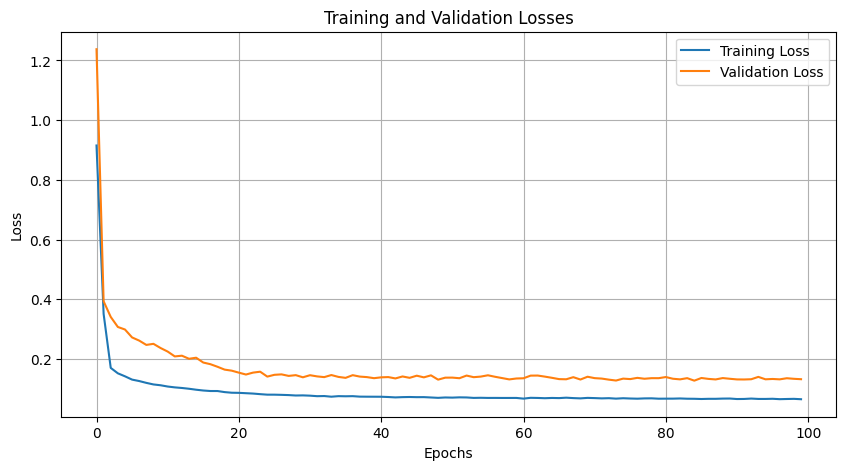

/tmp/ipykernel_31/3105391348.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
Testing: 100%|‚ñà‚


FINAL TEST RESULTS
Loss:     0.0497
MAE:      0.1212
RMSE:     0.2231
R¬≤:       0.9287


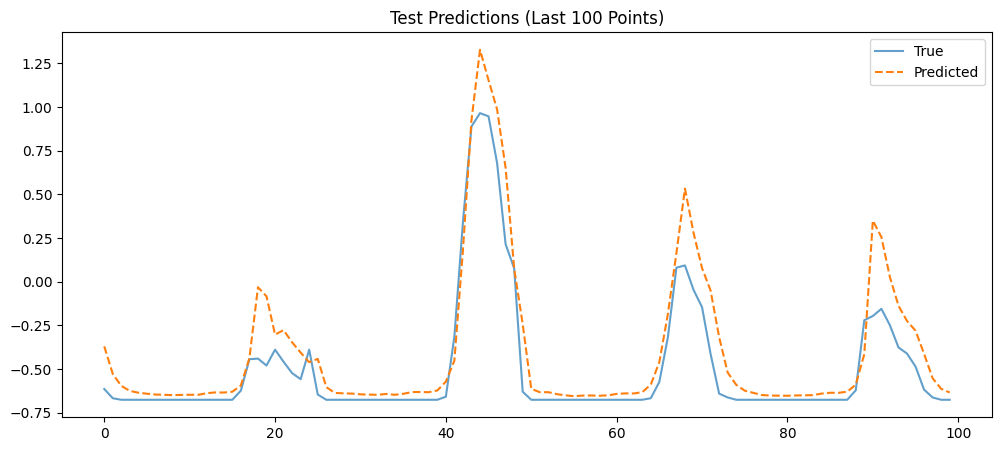

In [64]:
torch.save(model.state_dict(), 'energy_generation_model.pth')

print("Model saved and Running final evaluation...")
# 1. Tracer les courbes d'apprentissage
plot_losses()

# 2. √âvaluation finale sur le test set
test_results = test_model()

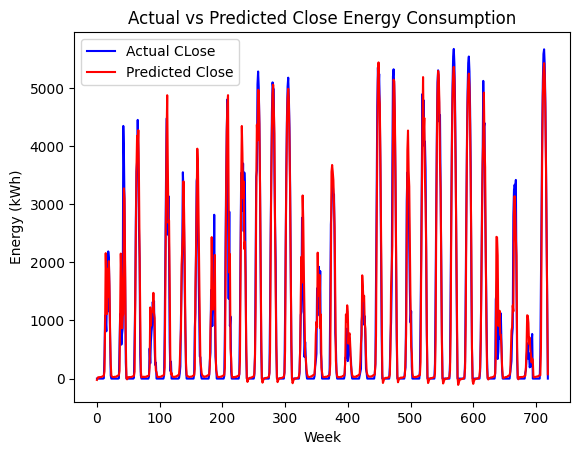

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [65]:
# Assure que le mod√®le est sur le CPU
model_cpu = model.to('cpu')
model_cpu.eval()

# Assure que les donn√©es sont sur le CPU aussi
X_train_cpu = X_train.to('cpu')

with torch.no_grad():
    predicted = model_cpu(X_train_cpu).numpy()


train_predictions_normalized = predicted.flatten()
train_predictions = scaler.inverse_transform(train_predictions_normalized.reshape(-1, 1))

Y_train_normal = scaler.inverse_transform(Y_train.reshape(-1, 1))

plt.plot(Y_train_normal[-24*30*1:], label='Actual CLose', color='blue')
plt.plot(train_predictions[-24*30*1:], label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))

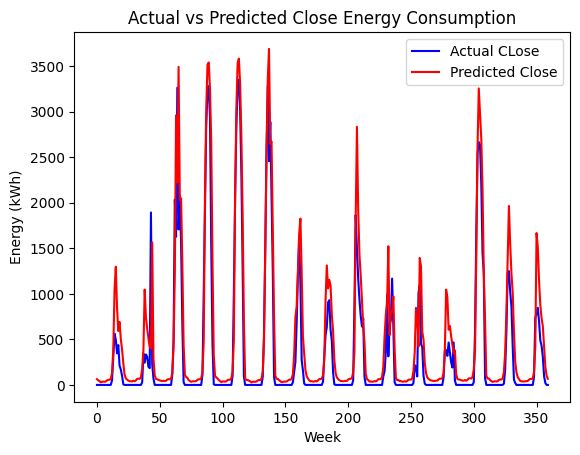

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [67]:
# Assure que les donn√©es sont sur le CPU aussi
X_test_cpu = X_test.to('cpu')

with torch.no_grad():
    predicted = model_cpu(X_test_cpu).numpy()


test_predictions_normalized = predicted.flatten()
test_predictions = scaler.inverse_transform(test_predictions_normalized.reshape(-1, 1))

Y_test_normal = scaler.inverse_transform(Y_test.reshape(-1, 1))

plt.plot(Y_test_normal[-24*15*1:], label='Actual CLose', color='blue')
plt.plot(test_predictions[-24*15*1:], label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))